# Machine Learning Models for SCOPE: Logistic Regression
Models will be coded here, but the official write up will be in the RMarkdown document.

In [ ]:
# load the data files
import pandas as pd
import numpy as np
from pymodelutils import utils
from imblearn.over_sampling import SMOTE

logs = pd.read_csv("data/metis_logs.csv")
logs['run_date'] = logs['run_date'].astype('datetime64[ns]')
logs['is_alert'] = (np.where(logs['is_alert'] == 'f', 0, 1))
logs['is_campaign'] = np.where(logs['campaign_id'] > 0, 1, 0)
logs = logs.drop(columns=['client_id', 'partner_id', 'campaign_id'])
AS_expert_logs = logs[logs.username.isin(['d.sewell', 'o.pierce', 'l.molter'])]
TS_expert_logs = logs[logs.username.isin(['a.mcgee', 's.gallardo', 'f.pillot'])]
RexT_expert_logs = logs[logs.username == 'l.molter']
logs.head()

In [2]:
# filter down to show the average opinion (0 means no alert, 1 means alert)
logs = logs.groupby(['series', 'kpi', 'run_date']).mean().round(0).reset_index()
logs['is_alert'].describe()

count    9674.000000
mean        0.166425
std         0.372481
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: is_alert, dtype: float64

In [ ]:
AS_data = pd.read_csv("data/python_AS.csv")
AS_data.head()

In [ ]:
TS_data = pd.read_csv("data/python_TS.csv")
TS_data.head()

In [ ]:
RexT_data = pd.read_csv("data/python_RexT.csv")
RexT_data.head()

## Data Prep
R has already filtered down the data to the days we are going to use and marked what is disqualified. We still have to handle the feature selection and one-hot encoding of select columns though. We also need to normalize it since out KPIs behave quite differently.

In [ ]:
# add column for AS to tell if it is campaign level or not
AS_data['is_campaign'] = np.where(AS_data['campaign_id'] > 0, 1, 0)

# drop the data we don't need for the model or for matching back to the logs
AS_keep_columns = ['series', 'day', 'run_date', 'kpi', 'value', 'disqualified', 'is_campaign']
TS_keep_columns = ['series', 'day', 'run_date', 'site_type', 'event_name', 
                   'kpi', 'value', 'disqualified']
RexT_drop_columns = ['ranking',
                    'day_of_week',
                    'day_of_month',
                    'month_of_year',
                    'day_of_year',
                    'week_of_year']

AS_data = AS_data[AS_keep_columns]
TS_data = TS_data[TS_keep_columns]
RexT_data = RexT_data.drop(columns=RexT_drop_columns)

In [ ]:
AS_data.head()

In [ ]:
TS_data.head()

In [ ]:
RexT_data.head()

In [ ]:
# add a new column to determine how many days before the run_date the day column entry is
# this will enable us to pivot that data into separate columns for the features of our model
utils.prep_dates(AS_data)
utils.prep_dates(TS_data)
utils.prep_dates(RexT_data)

In [ ]:
# inner joins to logs
AS_expert_data = pd.merge(AS_data, AS_expert_logs, on=['series', 'run_date', 'kpi', 'is_campaign'], how='inner')
TS_expert_data = pd.merge(TS_data, TS_expert_logs, on=['series', 'run_date', 'kpi', 'site_type', 'event_name'], how='inner')
RexT_expert_data = pd.merge(RexT_data, RexT_expert_logs, on=['series', 'run_date', 'kpi', 'country', 'subregion', 'region'], how='inner')

AS_data = pd.merge(AS_data, logs, on=['series', 'run_date', 'kpi', 'is_campaign'], how='inner')
TS_data = pd.merge(TS_data, logs, on=['series', 'run_date', 'kpi'], how='inner')
RexT_data = pd.merge(RexT_data, logs, on=['series', 'run_date', 'kpi'], how='inner')

In [ ]:
# filter out the disqualified data (AS and TS data only)
AS_disqualified = AS_data[AS_data.disqualified]
TS_disqualified = TS_data[TS_data.disqualified]
AS_expert_disqualified = AS_expert_data[AS_expert_data.disqualified]
TS_expert_disqualified = TS_expert_data[TS_expert_data.disqualified]

# valid for model (AS and TS data only)
valid_AS_raw = AS_data[~(AS_data.disqualified)]
valid_TS_raw = TS_data[~(TS_data.disqualified)]
valid_AS_expert_raw = AS_expert_data[~(AS_expert_data.disqualified)]
valid_TS_expert_raw = TS_expert_data[~(TS_expert_data.disqualified)]

# keep a copy of the raw RexT data
RexT_data_raw = RexT_data.copy(deep=True)

In [ ]:
# final preparations to the data shape for use in the model
valid_AS = utils.data_prep_pipeline(valid_AS_raw.copy(), 
                                      indices=['series', 'run_date', 'kpi', 'is_campaign', 'is_alert'], 
                                      cols=['kpi'],
                                      scaling_method=['standardize', 'min_max', 'percent_of_mean'],
                                   weighting_type='linear',
                                   summary_stats=True)
disqualified_AS = utils.data_prep_pipeline(AS_disqualified.copy(), 
                                          indices=['series', 'run_date', 'kpi', 'is_campaign', 'is_alert'], 
                                          cols=['kpi'],
                                          scaling_method=['standardize', 'min_max', 'percent_of_mean'],
                                   weighting_type='linear',
                                   summary_stats=True)
valid_TS = utils.data_prep_pipeline(valid_TS_raw.copy(), 
                                      indices=['series', 'run_date', 'site_type', 'event_name', 'is_alert'], 
                                      cols=['site_type', 'event_name'],
                                      scaling_method=['standardize', 'min_max', 'percent_of_mean'],
                                   weighting_type='exponential',
                                   summary_stats=True)
disqualified_TS = utils.data_prep_pipeline(TS_disqualified.copy(), 
                                          indices=['series', 'run_date', 'site_type', 'event_name', 'is_alert'], 
                                          cols=['site_type', 'event_name'],
                                          scaling_method=['standardize', 'min_max', 'percent_of_mean'],
                                   weighting_type='exponential',
                                   summary_stats=True)
valid_RexT = utils.data_prep_pipeline(utils.clean_regions(RexT_data), 
                                       indices=['isCountry', 'isSubregion', 'isRegion', 
                                                'series', 'run_date', 'is_alert'], 
                                       cols=['series'],
                                       scaling_method=['standardize', 'min_max', 'percent_of_mean'],
                                   weighting_type=None)

In [ ]:
# final preparations to the data shape for use in the model
valid_AS_expert = utils.data_prep_pipeline(valid_AS_expert_raw.copy(), 
                                      indices=['series', 'run_date', 'kpi', 'is_campaign', 'is_alert'], 
                                      cols=['kpi'],
                                      scaling_method=['standardize', 'min_max', 'percent_of_mean'],
                                   weighting_type='linear',
                                   summary_stats=True)
valid_TS_expert = utils.data_prep_pipeline(valid_TS_expert_raw.copy(), 
                                      indices=['series', 'run_date', 'site_type', 'event_name', 'is_alert'], 
                                      cols=['site_type', 'event_name'],
                                      scaling_method=['standardize', 'min_max', 'percent_of_mean'],
                                   weighting_type='exponential',
                                   summary_stats=True)
valid_RexT_expert = utils.data_prep_pipeline(utils.clean_regions(RexT_expert_data), 
                                       indices=['isCountry', 'isSubregion', 'isRegion', 
                                                'series', 'run_date', 'is_alert'], 
                                       cols=['series'],
                                       scaling_method=['standardize', 'min_max', 'percent_of_mean'],
                                   weighting_type=None)

In [ ]:
# for the TS data we need to drop event_name_SITE LEVEL because it will always be the same as site_type_SITE LEVEL
valid_TS = {key : value.drop(columns='event_name_SITE LEVEL') for key, value in valid_TS.items()}

# add back missing columns for the disqualified data
disqualified_TS['min_max']['time_delta_24'], disqualified_TS['min_max']['time_delta_25'] = (0,0)
disqualified_TS['min_max']['site_type_SITE LEVEL'], disqualified_TS['min_max']['site_type_aios'] = (0,0)
disqualified_TS['min_max']['time_delta_diff_23'], disqualified_TS['min_max']['time_delta_diff_24'] = (0,0)

In [ ]:
valid_AS['min_max'].head()

In [ ]:
valid_TS['percent_of_mean'].head()

In [ ]:
valid_RexT['standardize'].head()

## Modelling
Now that all the data is prepped, we can start building some logistic regression models to test on. We also need to split our data into a test and train set being careful that we have an equal proportion of anomalies in each (because they are very few, we have to make sure we don't train or test the model on all the anomalies while the other gets none).

### Split Data into Train and Test Sets

In [ ]:
from sklearn.model_selection import train_test_split

# scaling method to test
AS_scaler = 'min_max'
TS_scaler = 'min_max'
RexT_scaler = 'min_max'

# separate out data into feature matrices and target arrays
AS_features = valid_AS[AS_scaler][[col for col in valid_AS[AS_scaler].columns 
                        if col not in ['series', 'run_date', 'is_alert']]] # this needs to be the model features
AS_targets = valid_AS[AS_scaler]['is_alert'] # this needs to be the results from the logs (only)

TS_features = valid_TS[TS_scaler][[col for col in valid_TS[TS_scaler].columns 
                        if col not in ['series', 'run_date', 'is_alert']]]
TS_targets = valid_TS[TS_scaler]['is_alert']

RexT_features = valid_RexT[RexT_scaler][[col for col in valid_RexT[RexT_scaler].columns 
                           if col not in ['run_date', 'is_alert']]]
RexT_targets = valid_RexT[RexT_scaler]['is_alert']
test_RexT_features = RexT_features.drop(columns=[col for col in RexT_features.columns 
                                                 if 'series' in col
                                                or col in ['isCountry', 'isSubregion', 'isRegion']])

# separate out data into feature matrices and target arrays
AS_expert_features = valid_AS_expert[AS_scaler][[col for col in valid_AS_expert[AS_scaler].columns 
                        if col not in ['series', 'run_date', 'is_alert']]] # this needs to be the model features
AS_expert_targets = valid_AS_expert[AS_scaler]['is_alert'] # this needs to be the results from the logs (only)

TS_expert_features = valid_TS_expert[TS_scaler][[col for col in valid_TS_expert[TS_scaler].columns 
                        if col not in ['series', 'run_date', 'is_alert', 'event_name_SITE LEVEL']]]
TS_expert_targets = valid_TS_expert[TS_scaler]['is_alert']

RexT_expert_features = valid_RexT_expert[RexT_scaler][[col for col in valid_RexT_expert[RexT_scaler].columns 
                           if col not in ['run_date', 'is_alert']]]
RexT_expert_targets = valid_RexT_expert[RexT_scaler]['is_alert']
test_expert_RexT_features = RexT_expert_features.drop(columns=[col for col in RexT_expert_features.columns 
                                                 if 'series' in col
                                                or col in ['isCountry', 'isSubregion', 'isRegion']])

# split into a train and test set without differences
AS_X_train, AS_X_test, AS_y_train, AS_y_test = train_test_split(AS_features[[col for col in AS_features.columns 
                                                                             if 'diff' not in col]], 
                                                                AS_targets, 
                                                                test_size=0.2, 
                                                                random_state=25)
TS_X_train, TS_X_test, TS_y_train, TS_y_test = train_test_split(TS_features[[col for col in TS_features.columns 
                                                                             if 'diff' not in col]], 
                                                                TS_targets, 
                                                                test_size=0.2, 
                                                                random_state=25)
RexT_X_train, RexT_X_test, RexT_y_train, RexT_y_test = train_test_split(test_RexT_features[[col for col in 
                                                                                            test_RexT_features.columns
                                                                                            if 'diff' not in col]], 
                                                                        RexT_targets, 
                                                                        test_size=0.5, 
                                                                        random_state=25)

# split into a train and test set with differences
AS_X_train_diff, AS_X_test_diff, AS_y_train_diff, AS_y_test_diff = train_test_split(AS_features, 
                                                                                    AS_targets, 
                                                                                    test_size=0.2, 
                                                                                    random_state=25)
TS_X_train_diff, TS_X_test_diff, TS_y_train_diff, TS_y_test_diff = train_test_split(TS_features, 
                                                                                    TS_targets, 
                                                                                    test_size=0.2, 
                                                                                    random_state=25)
RexT_X_train_diff, RexT_X_test_diff, RexT_y_train_diff, RexT_y_test_diff = train_test_split(test_RexT_features, 
                                                                                            RexT_targets, 
                                                                                            test_size=0.5, 
                                                                                            random_state=25)

# split into a train and test set for expert
AS_X_train_expert, AS_X_test_expert, AS_y_train_expert, AS_y_test_expert = train_test_split(AS_expert_features, 
                                                                                            AS_expert_targets, 
                                                                                            test_size=0.2, 
                                                                                            random_state=25)
TS_X_train_expert, TS_X_test_expert, TS_y_train_expert, TS_y_test_expert = train_test_split(TS_expert_features, 
                                                                                            TS_expert_targets, 
                                                                                            test_size=0.2, 
                                                                                            random_state=25)
RexT_X_train_expert, RexT_X_test_expert, RexT_y_train_expert, RexT_y_test_expert = train_test_split(test_expert_RexT_features, 
                                                                                                    RexT_expert_targets, 
                                                                                                    test_size=0.5, 
                                                                                                    random_state=25)

# split into a train and test set with differences and extra anomalies
AS_X_train_oversampled, AS_y_train_oversampled = SMOTE(random_state=25, ratio='minority')\
                                                    .fit_sample(AS_X_train_diff, AS_y_train_diff)
TS_X_train_oversampled, TS_y_train_oversampled = SMOTE(random_state=25, ratio='minority')\
                                                    .fit_sample(TS_X_train_diff, TS_y_train_diff)
RexT_X_train_oversampled, RexT_y_train_oversampled = SMOTE(random_state=25, ratio='minority')\
                                                        .fit_sample(RexT_X_train_diff, RexT_y_train_diff)

Let's make sure that we have similar percentage of anomalies in our test and train sets. 

In [20]:
# AS
print('Total alerts in training set: ' + str(AS_y_train.sum()))
print('Total alerts in test set: ' + str(AS_y_test.sum()))
pd.DataFrame({'train' : AS_y_train.value_counts(normalize=True), 
              'test' : AS_y_test.value_counts(normalize=True)})

Total alerts in training set: 831.0
Total alerts in test set: 215.0


,test,train
0.0,0.782828,0.790045
1.0,0.217172,0.209955


In [21]:
# AS
print('Total alerts in OVERSAMPLED ALERTS training set: ' + str(AS_y_train_oversampled.sum()))
print('Total alerts in regular test set: ' + str(AS_y_test_diff.sum()))
pd.DataFrame({'train' : pd.DataFrame(AS_y_train_oversampled).iloc[:,0].value_counts(normalize=True), 
              'test' : AS_y_test_diff.value_counts(normalize=True)})

Total alerts in OVERSAMPLED ALERTS training set: 3127.0
Total alerts in regular test set: 215.0


,test,train
0.0,0.782828,0.5
1.0,0.217172,0.5


In [22]:
# TS
print('Total alerts in training set: ' + str(TS_y_train.sum()))
print('Total alerts in test set: ' + str(TS_y_test.sum()))
pd.DataFrame({'train' : TS_y_train.value_counts(normalize=True), 
              'test' : TS_y_test.value_counts(normalize=True)})

Total alerts in training set: 237.0
Total alerts in test set: 58.0


,test,train
0.0,0.916667,0.91484
1.0,0.083333,0.08516


In [23]:
# TS
print('Total alerts in OVERSAMPLED ALERTS training set: ' + str(TS_y_train_oversampled.sum()))
print('Total alerts in OVERSAMPLED ALERTS test set: ' + str(TS_y_test_diff.sum()))
pd.DataFrame({'train' : pd.DataFrame(TS_y_train_oversampled).iloc[:,0].value_counts(normalize=True), 
              'test' : TS_y_test_diff.value_counts(normalize=True)})

Total alerts in OVERSAMPLED ALERTS training set: 2546.0
Total alerts in OVERSAMPLED ALERTS test set: 58.0


,test,train
0.0,0.916667,0.5
1.0,0.083333,0.5


In [24]:
# RexT
print('Total alerts in training set: ' + str(RexT_y_train.sum()))
print('Total alerts in test set: ' + str(RexT_y_test.sum()))
pd.DataFrame({'train' : RexT_y_train.value_counts(normalize=True), 
              'test' : RexT_y_test.value_counts(normalize=True)})

Total alerts in training set: 9.0
Total alerts in test set: 13.0


,test,train
0.0,0.868687,0.909091
1.0,0.131313,0.090909


In [25]:
# RexT
print('Total alerts in OVERSAMPLED ALERTS training set: ' + str(RexT_y_train_oversampled.sum()))
print('Total alerts in OVERSAMPLED ALERTS test set: ' + str(RexT_y_test_diff.sum()))
pd.DataFrame({'train' : pd.DataFrame(RexT_y_train_oversampled).iloc[:,0].value_counts(normalize=True), 
              'test' : RexT_y_test_diff.value_counts(normalize=True)})

Total alerts in OVERSAMPLED ALERTS training set: 90.0
Total alerts in OVERSAMPLED ALERTS test set: 13.0


,test,train
0.0,0.868687,0.5
1.0,0.131313,0.5


### Logistic Regression without Differences

In [26]:
%%capture 
# ^ don't print errors about precision, recall, F1-score being 0

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, fbeta_score, zero_one_loss

logistic_regression = LogisticRegression(penalty='l2', tol=0.0001, C=1.0, 
                                         fit_intercept=True, random_state=42, 
                                         max_iter=100, verbose=0, n_jobs=-1)
parameters = {'penalty' : ('l2', 'l1'),
              'C':[i/10 for i in range(11) if i > 0],
#              'fit_intercept' : [True, False],
             'class_weight' : ['balanced', None],
             'intercept_scaling' : [0.5, 1, 1.5, 2, 2.5, 3]}

scoring = {'auc': 'roc_auc',
           # only reports on alerts flagged
           'precision_binary' : make_scorer(precision_score, average='binary'), 
           # global count of everything like confusion matrix
           'precision_micro' : make_scorer(precision_score, average='micro'), 
           # metrics calculated for each label and averaged evenly (regardless of class size)
#            'precision_macro' : make_scorer(precision_score, average='macro'), 
           # same as macro but with a weighted average to account for imbalance of the classes
           'precision_weighted' : make_scorer(precision_score, average='weighted'),
          'recall_weighted' : make_scorer(recall_score, average='weighted'),
          'recall_binary' : make_scorer(recall_score, average='binary'),
          'recall_micro' : make_scorer(recall_score, average='micro'),
#           'recall_macro' : make_scorer(recall_score, average='macro'),
          'f1_score_weighted' : make_scorer(f1_score, average='weighted'),
          'f1_score_binary' : make_scorer(f1_score, average='binary'),
          'f1_score_micro' : make_scorer(f1_score, average='micro'),
#           'f1_score_macro' : make_scorer(f1_score, average='macro'),
           # emphasize recall more
          'f2_score_weighted' : make_scorer(fbeta_score, beta=2, average='weighted'), 
          'f2_score_binary' : make_scorer(fbeta_score, beta=2, average='binary'),
          'f2_score_micro' : make_scorer(fbeta_score, beta=2, average='micro'),
#           'f2_score_macro' : make_scorer(fbeta_score, beta=2, average='macro'),
           # emphasize precision more
          'f0.5_score_weighted' : make_scorer(fbeta_score, beta=0.5, average='weighted'), 
          'f0.5_score_binary' : make_scorer(fbeta_score, beta=0.5, average='binary'),
          'f0.5_score_micro' : make_scorer(fbeta_score, beta=0.5, average='micro'),
#           'f0.5_score_macro' : make_scorer(fbeta_score, beta=0.5, average='macro'),
           # percent of misclassifications
          'zero_one_loss_normalized' : make_scorer(zero_one_loss, greater_is_better=False), 
           # number of misclassifications
          'zero_one_loss_count' : make_scorer(zero_one_loss, greater_is_better=False, 
                                              normalize=False), 
          'accuracy' : 'accuracy'}

# pick '_weighted' if you want to be right on each class proportionally 
# ('macro' isn't really appropriate due to the class imbalance)
# pick '_binary' if you want to perform best on the alert class
# pick '_micro' to count globally all TP, FP, TN, FN (like confusion matrix)
# so for our purposes 'f1_score' with one of the above is likely to be the best
refit_AS = 'precision_micro'
refit_TS = 'precision_micro'
refit_RexT = 'auc'

AS_logistic_grid = GridSearchCV(estimator=logistic_regression, param_grid=parameters, 
                                scoring=scoring, refit=refit_AS, return_train_score=True)
TS_logistic_grid = GridSearchCV(estimator=logistic_regression, param_grid=parameters, 
                                scoring=scoring, refit=refit_TS, return_train_score=True)
RexT_logistic_grid = GridSearchCV(estimator=logistic_regression, param_grid=parameters, 
                                  scoring=scoring, refit=refit_RexT, return_train_score=True)

# fit the models to find the best version
AS_logistic_regression_model = AS_logistic_grid.fit(AS_X_train, AS_y_train)
TS_logistic_regression_model = TS_logistic_grid.fit(TS_X_train, TS_y_train)
RexT_logistic_regression_model = RexT_logistic_grid.fit(RexT_X_train, RexT_y_train)

#### Best Logistic Regression Models
##### AS
The model seems to pick up that the most important features are whether or not it is a campaign, the 5 most recent dates (time_delta's 1-5). TAC, margin, and RexT euro have very negative coefficients most likely because we don't see many alerts there so the log odds are small and the exponential of those values is near 0. Clicks, displays, and spend are more likely.

In [27]:
print(AS_logistic_regression_model.best_estimator_)
print(refit_AS + ' (Mean cross-validated score of the best_estimator): ' + \
      str(AS_logistic_regression_model.best_score_))
for col, coef in zip(AS_X_train.columns, AS_logistic_regression_model.best_estimator_.coef_[0]):
    print(col + '\t' + str(round(coef, 2)))

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=0.5, max_iter=100, multi_class='ovr',
          n_jobs=-1, penalty='l1', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)
precision_micro (Mean cross-validated score of the best_estimator): 0.7976250631632138
is_campaign	0.03
time_delta_01	0.3
time_delta_02	0.11
time_delta_03	0.03
time_delta_04	0.0
time_delta_05	0.0
time_delta_06	0.05
time_delta_07	0.0
time_delta_08	-0.01
time_delta_09	0.0
time_delta_10	0.0
time_delta_11	0.0
time_delta_12	0.0
time_delta_13	0.0
time_delta_14	0.0
time_delta_15	0.0
time_delta_16	0.0
time_delta_17	0.0
time_delta_18	0.0
time_delta_19	0.0
time_delta_20	0.0
time_delta_21	0.0
time_delta_22	0.0
time_delta_23	0.0
time_delta_24	0.0
time_delta_25	0.0
kpi_clicks	0.0
kpi_client_rext	0.0
kpi_conversions	0.0
kpi_cos	0.0
kpi_cr	0.0
kpi_ctr	0.0
kpi_displays	0.0
kpi_margin	-1.33
kpi_order_value	0.0
kpi_rext_euro	-0.96
kpi_spend	0

##### TS

In [28]:
print(TS_logistic_regression_model.best_estimator_)
print(refit_TS + ' (Mean cross-validated score of the best_estimator): ' + \
      str(TS_logistic_regression_model.best_score_))
for col, coef in zip(TS_X_train.columns, TS_logistic_regression_model.best_estimator_.coef_[0]):
    print(col + '\t' + str(round(coef, 2)))

LogisticRegression(C=0.4, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=0.5, max_iter=100, multi_class='ovr',
          n_jobs=-1, penalty='l1', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)
precision_micro (Mean cross-validated score of the best_estimator): 0.9198706431908013
time_delta_01	3.96
time_delta_02	0.0
time_delta_03	0.0
time_delta_04	0.0
time_delta_05	0.0
time_delta_06	0.0
time_delta_07	0.0
time_delta_08	0.0
time_delta_09	0.0
time_delta_10	0.0
time_delta_11	0.0
time_delta_12	0.0
time_delta_13	0.0
time_delta_14	0.0
time_delta_15	0.0
time_delta_16	0.0
time_delta_17	0.0
time_delta_18	0.0
time_delta_19	0.0
time_delta_20	0.0
time_delta_21	0.0
time_delta_22	0.0
time_delta_23	0.0
time_delta_24	0.0
time_delta_25	0.0
site_type_SITE LEVEL	0.0
site_type_aa	0.0
site_type_aios	-0.18
site_type_d	-0.6
site_type_m	0.11
site_type_t	-0.05
event_name_basket	-0.09
event_name_homepage	-0.06
event_name_listing	0.0
event_na

##### RexT

In [29]:
print(RexT_logistic_regression_model.best_estimator_)
print(refit_RexT + ' (Mean cross-validated score of the best_estimator): ' + \
      str(RexT_logistic_regression_model.best_score_))
for col, coef in zip(RexT_X_train.columns, RexT_logistic_regression_model.best_estimator_.coef_[0]):
    print(col + '\t' + str(round(coef, 2)))

LogisticRegression(C=0.3, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=3, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
auc (Mean cross-validated score of the best_estimator): 0.974074074074074
time_delta_01	2.35
time_delta_02	-0.3
time_delta_03	-0.36
time_delta_04	0.0
time_delta_05	0.0
time_delta_06	0.0
time_delta_07	0.0
time_delta_08	0.0
time_delta_09	0.0
time_delta_10	-0.25
time_delta_11	0.0
time_delta_12	0.0
time_delta_13	0.0
time_delta_14	0.0
time_delta_15	0.0
time_delta_16	0.0
time_delta_17	0.0
time_delta_18	0.0
time_delta_19	0.0
time_delta_20	0.0
time_delta_21	0.0
time_delta_22	0.0
time_delta_23	0.0
time_delta_24	-0.22
time_delta_25	0.0
time_delta_26	0.0
time_delta_27	0.0
time_delta_28	0.0
time_delta_29	0.0
time_delta_30	0.0


#### Model Evaluation
##### ROC Curve

In [30]:
from sklearn.metrics import roc_curve, auc

AS_y_prob_fit = AS_logistic_regression_model.predict_proba(AS_X_test)
TS_y_prob_fit = TS_logistic_regression_model.predict_proba(TS_X_test)
RexT_y_prob_fit = RexT_logistic_regression_model.predict_proba(RexT_X_test)
# print(AS_logistic_regression_model.classes_) # make sure that positive (1) is index 1

AS_logistic_reg_roc_curve = roc_curve(AS_y_test, AS_y_prob_fit[:,1], pos_label=1) # returns tuple: fpr, tpr, thresholds
AS_logistic_reg_roc_curve_AUC = auc(AS_logistic_reg_roc_curve[0], 
                                    AS_logistic_reg_roc_curve[1]) # needs fpr, tpr
TS_logistic_reg_roc_curve = roc_curve(TS_y_test, TS_y_prob_fit[:,1], pos_label=1)
TS_logistic_reg_roc_curve_AUC = auc(TS_logistic_reg_roc_curve[0], 
                                    TS_logistic_reg_roc_curve[1])
RexT_logistic_reg_roc_curve = roc_curve(RexT_y_test, RexT_y_prob_fit[:,1], pos_label=1)
RexT_logistic_reg_roc_curve_AUC = auc(RexT_logistic_reg_roc_curve[0], 
                                      RexT_logistic_reg_roc_curve[1])

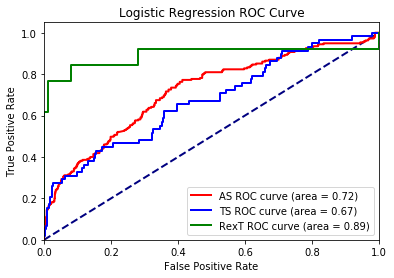

In [27]:
# ROC Curve without 1 period differences
utils.model_roc_curves(roc_data_dict={'AS' : AS_logistic_reg_roc_curve, 
                                'TS' : TS_logistic_reg_roc_curve, 
                                'RexT' : RexT_logistic_reg_roc_curve}, 
                 auc_dict={'AS' : AS_logistic_reg_roc_curve_AUC, 
                           'TS' : TS_logistic_reg_roc_curve_AUC, 
                           'RexT' : RexT_logistic_reg_roc_curve_AUC}, 
                 method_name='Logistic Regression without Weights')

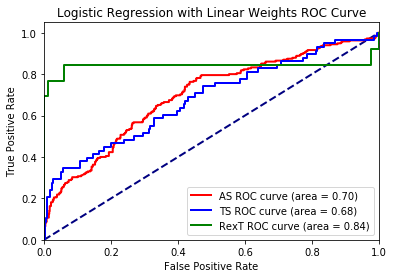

In [34]:
# ROC Curve without 1 period differences
utils.model_roc_curves(roc_data_dict={'AS' : AS_logistic_reg_roc_curve, 
                                'TS' : TS_logistic_reg_roc_curve, 
                                'RexT' : RexT_logistic_reg_roc_curve}, 
                 auc_dict={'AS' : AS_logistic_reg_roc_curve_AUC, 
                           'TS' : TS_logistic_reg_roc_curve_AUC, 
                           'RexT' : RexT_logistic_reg_roc_curve_AUC}, 
                 method_name='Logistic Regression with Linear Weights')

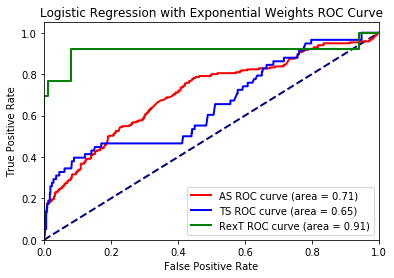

In [27]:
# ROC Curve without 1 period differences
utils.model_roc_curves(roc_data_dict={'AS' : AS_logistic_reg_roc_curve, 
                                'TS' : TS_logistic_reg_roc_curve, 
                                'RexT' : RexT_logistic_reg_roc_curve}, 
                 auc_dict={'AS' : AS_logistic_reg_roc_curve_AUC, 
                           'TS' : TS_logistic_reg_roc_curve_AUC, 
                           'RexT' : RexT_logistic_reg_roc_curve_AUC}, 
                 method_name='Logistic Regression with Exponential Weights')

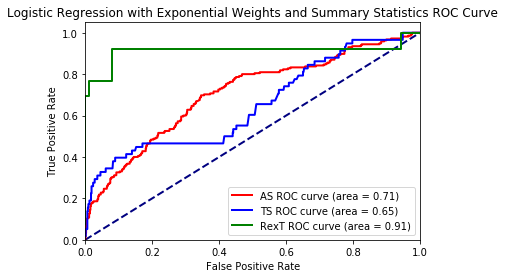

In [28]:
# ROC Curve without 1 period differences
utils.model_roc_curves(roc_data_dict={'AS' : AS_logistic_reg_roc_curve, 
                                'TS' : TS_logistic_reg_roc_curve, 
                                'RexT' : RexT_logistic_reg_roc_curve}, 
                 auc_dict={'AS' : AS_logistic_reg_roc_curve_AUC, 
                           'TS' : TS_logistic_reg_roc_curve_AUC, 
                           'RexT' : RexT_logistic_reg_roc_curve_AUC}, 
                 method_name='Logistic Regression with Exponential Weights\nand Summary Statistics')

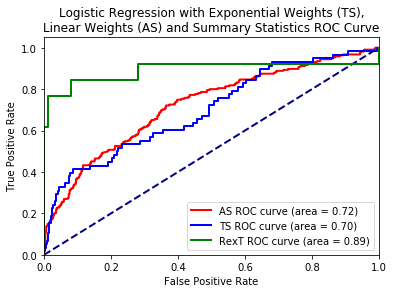

In [31]:
# ROC Curve without 1 period differences
utils.model_roc_curves(roc_data_dict={'AS' : AS_logistic_reg_roc_curve, 
                                'TS' : TS_logistic_reg_roc_curve, 
                                'RexT' : RexT_logistic_reg_roc_curve}, 
                 auc_dict={'AS' : AS_logistic_reg_roc_curve_AUC, 
                           'TS' : TS_logistic_reg_roc_curve_AUC, 
                           'RexT' : RexT_logistic_reg_roc_curve_AUC}, 
                 method_name='Logistic Regression with Exponential Weights (TS),\nLinear Weights (AS) and Summary Statistics')

##### Check Alert Counts at Certain Threshold

In [32]:
utils.threshold_results(AS_logistic_regression_model.predict_proba(AS_X_test),
                  TS_logistic_regression_model.predict_proba(TS_X_test),
                  RexT_logistic_regression_model.predict_proba(RexT_X_test))

0% threshold
AS alert count: 990
TS alert count: 696
RexT alert count: 99
---------------------------------------------------------
10% threshold
AS alert count: 823
TS alert count: 123
RexT alert count: 45
---------------------------------------------------------
20% threshold
AS alert count: 488
TS alert count: 23
RexT alert count: 31
---------------------------------------------------------
30% threshold
AS alert count: 220
TS alert count: 10
RexT alert count: 24
---------------------------------------------------------
40% threshold
AS alert count: 73
TS alert count: 3
RexT alert count: 17
---------------------------------------------------------
50% threshold
AS alert count: 28
TS alert count: 2
RexT alert count: 15
---------------------------------------------------------
60% threshold
AS alert count: 10
TS alert count: 2
RexT alert count: 11
---------------------------------------------------------
70% threshold
AS alert count: 6
TS alert count: 0
RexT alert count: 6
-----------

##### Confusion Matrix

TP to FP ratio: 1.43


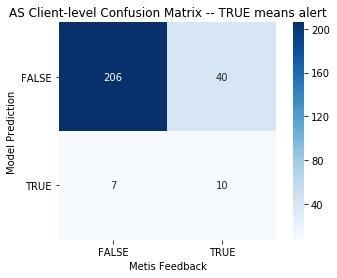

TP to FP ratio: 1.67


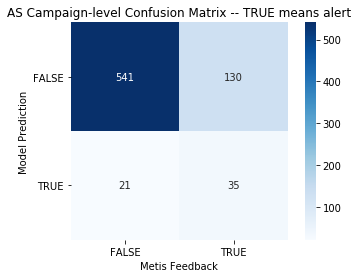

TP to FP ratio: 1.61


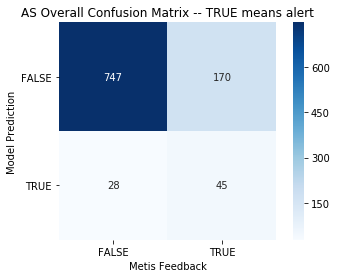

In [33]:
AS_threshold = 0.4
utils.confusion_matrix_visual(AS_y_test[AS_X_test.is_campaign == 0], 
                        AS_logistic_regression_model.predict_proba(AS_X_test[AS_X_test.is_campaign == 0])[:,1] \
                        >= AS_threshold, 'AS Client-level')
utils.confusion_matrix_visual(AS_y_test[AS_X_test.is_campaign == 1], 
                        AS_logistic_regression_model.predict_proba(AS_X_test[AS_X_test.is_campaign == 1])[:,1] \
                        >= AS_threshold, 'AS Campaign-level')
utils.confusion_matrix_visual(AS_y_test, 
                        AS_logistic_regression_model.predict_proba(AS_X_test)[:,1] \
                        >= AS_threshold, 'AS Overall')

TP to FP ratio: 1.0


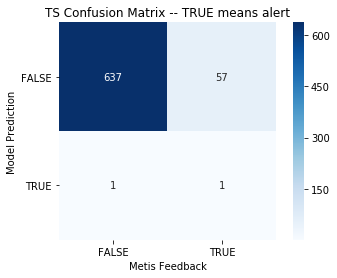

In [37]:
TS_threshold = 0.5
utils.confusion_matrix_visual(TS_y_test, 
                        TS_logistic_regression_model.predict_proba(TS_X_test)[:,1] \
                        >= TS_threshold,
                        'TS')

TP to FP ratio: 10.0


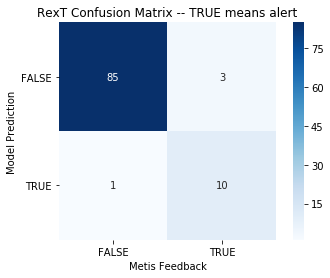

In [38]:
RexT_threshold = 0.6
utils.confusion_matrix_visual(RexT_y_test, 
                        RexT_logistic_regression_model.predict_proba(RexT_X_test)[:,1] \
                        >= RexT_threshold,
                        'RexT')

On disqualified data.

TP to FP ratio: 0.85


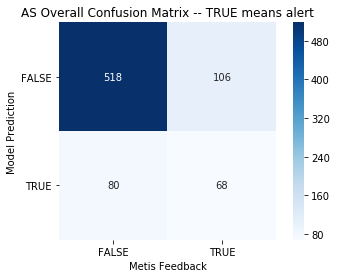

In [39]:
utils.confusion_matrix_visual(disqualified_AS['min_max']['is_alert'], 
                        AS_logistic_regression_model.predict_proba(disqualified_AS['min_max'].\
                                                                   drop([col for col in disqualified_AS['min_max'].columns
                                                                        if 'diff' in col or col in ['run_date', 'series', 'is_alert']], axis=1))[:,1] \
                        >= AS_threshold, 'AS Overall')

TP to FP ratio: 0.27


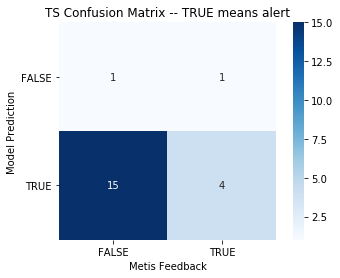

In [40]:
disqualified_TS['min_max']['time_delta_24'], disqualified_TS['min_max']['time_delta_25'] = (0,0)
disqualified_TS['min_max']['site_type_SITE LEVEL'], disqualified_TS['min_max']['site_type_aios'] = (0,0)
utils.confusion_matrix_visual(disqualified_TS['min_max']['is_alert'], 
                        TS_logistic_regression_model.predict_proba(disqualified_TS['min_max'].\
                                                                   drop([col for col in disqualified_TS['min_max'].columns
                                                                        if 'diff' in col or col in ['run_date', 'series', 'is_alert']], axis=1))[:,1] \
                        >= TS_threshold,
                        'TS')

#### Metrics

In [41]:
utils.classification_report_all(y_test_dict={'AS' : AS_y_test, 
                                       'TS' : TS_y_test, 
                                       'RexT' : RexT_y_test},
                         y_pred_dict={'AS' : 
                                      AS_logistic_regression_model.predict_proba(AS_X_test)[:,1] >= \
                                      AS_threshold, 
                                      'TS' : 
                                      TS_logistic_regression_model.predict_proba(TS_X_test)[:,1] >= \
                                      TS_threshold, 
                                      'RexT' : 
                                      RexT_logistic_regression_model.predict_proba(RexT_X_test)[:,1] >= \
                                      RexT_threshold})

AS results
             precision    recall  f1-score   support

      False       0.81      0.96      0.88       775
       True       0.62      0.21      0.31       215

avg / total       0.77      0.80      0.76       990

Percent misclassified: 20.0%
Count misclassified: 198
------------------------------------------------------
TS results
             precision    recall  f1-score   support

      False       0.92      1.00      0.96       638
       True       0.50      0.02      0.03        58

avg / total       0.88      0.92      0.88       696

Percent misclassified: 8.33%
Count misclassified: 58
------------------------------------------------------
RexT results
             precision    recall  f1-score   support

      False       0.97      0.99      0.98        86
       True       0.91      0.77      0.83        13

avg / total       0.96      0.96      0.96        99

Percent misclassified: 4.04%
Count misclassified: 4


#### Borderline Cases

In [42]:
%%capture

AS_log_reg_mismatches = utils.borderline_case_analysis(AS_threshold, AS_y_prob_fit, 
                                                       AS_X_test, valid_AS[AS_scaler], AS_data, 'AS')
TS_log_reg_mismatches = utils.borderline_case_analysis(TS_threshold, TS_y_prob_fit, 
                                                       TS_X_test, valid_TS[TS_scaler], TS_data, 'TS')
RexT_log_reg_mismatches = utils.borderline_case_analysis(RexT_threshold, RexT_y_prob_fit, 
                                                         RexT_X_test, valid_RexT[RexT_scaler], RexT_data, 'RexT')

In [43]:
# show the mismatch counts for the top ten
utils.mismatched_analysis(AS_log_reg_mismatches, 'AS')

is_campaign      0                                                1         \
kpi         clicks conversions ctr displays order_value conversions cos cr   
result                                                                       
FN               1           0   0        0           1           1   1  1   
FP               0           1   1        1           2           0   0  1   

is_campaign                     
kpi         displays spend tac  
result                          
FN                 1     0   4  
FP                 1     2   1

---------------------------------------
| Plotting the FP data.
---------------------------------------
| FP on KPI = conversions
---------------------------------------


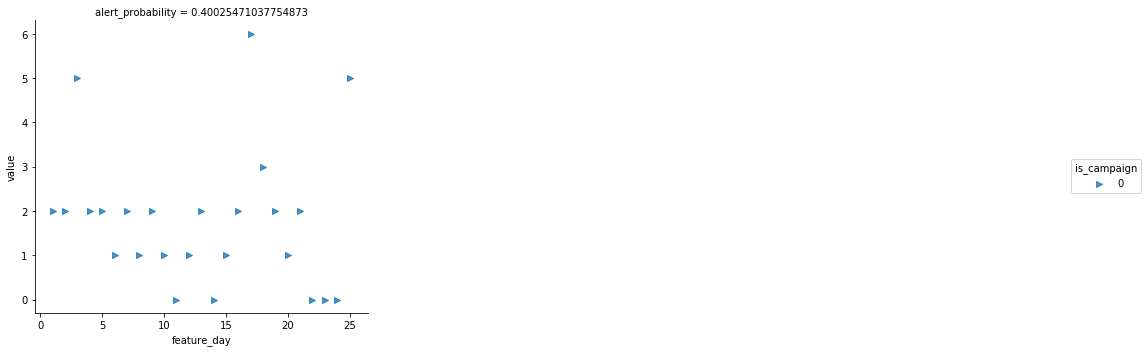

---------------------------------------
| FP on KPI = order_value
---------------------------------------


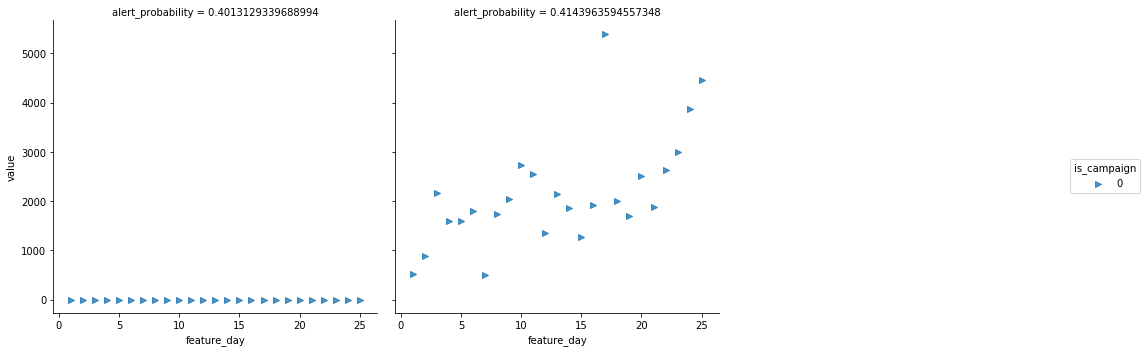

---------------------------------------
| FP on KPI = tac
---------------------------------------


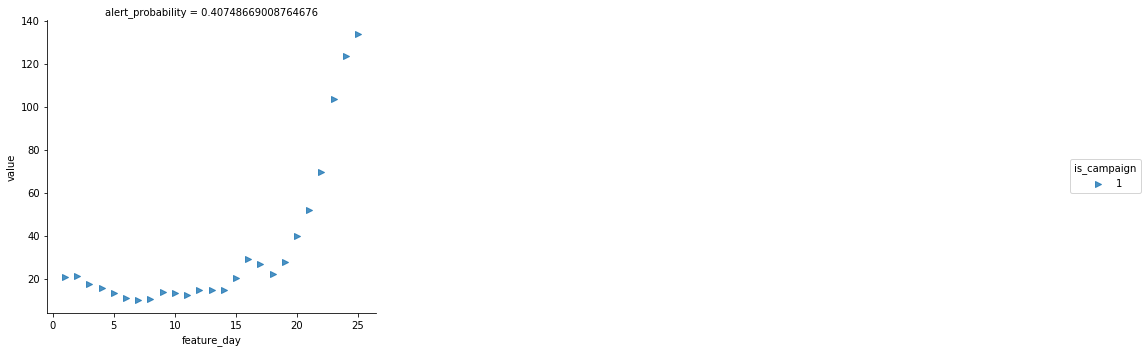

---------------------------------------
| FP on KPI = spend
---------------------------------------


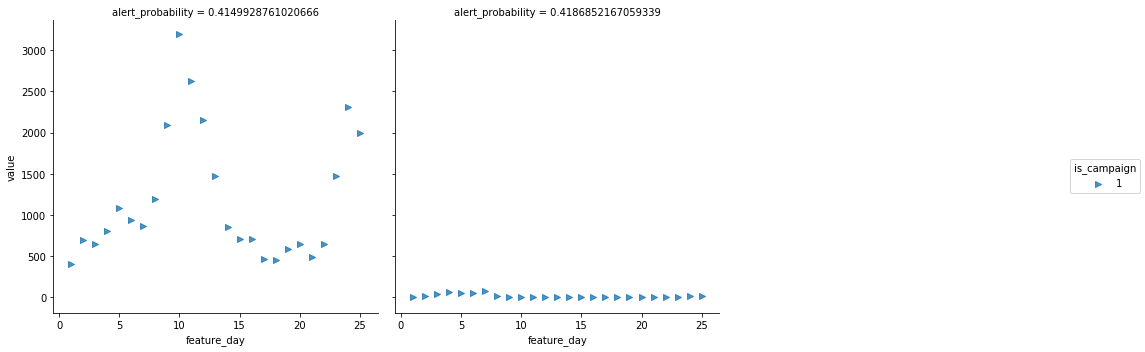

---------------------------------------
| FP on KPI = ctr
---------------------------------------


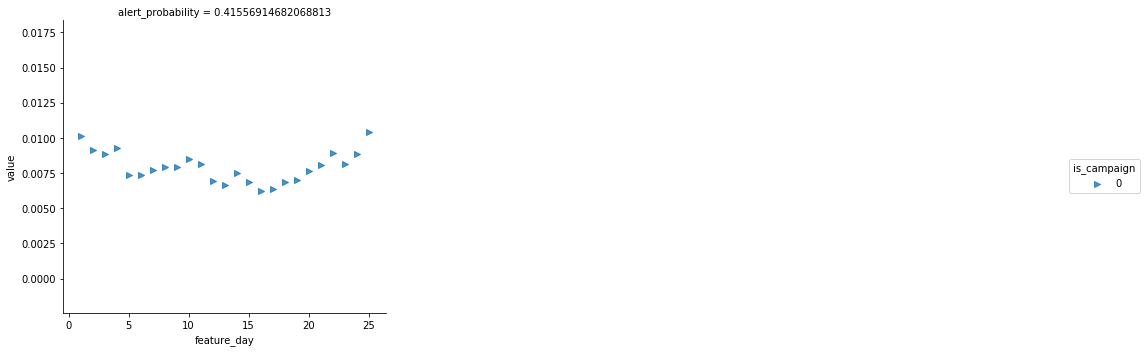

---------------------------------------
| FP on KPI = displays
---------------------------------------


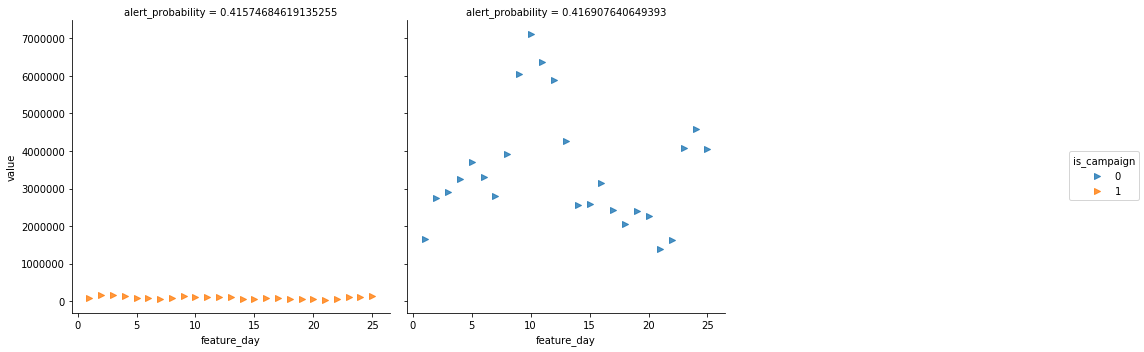

---------------------------------------
| FP on KPI = cr
---------------------------------------


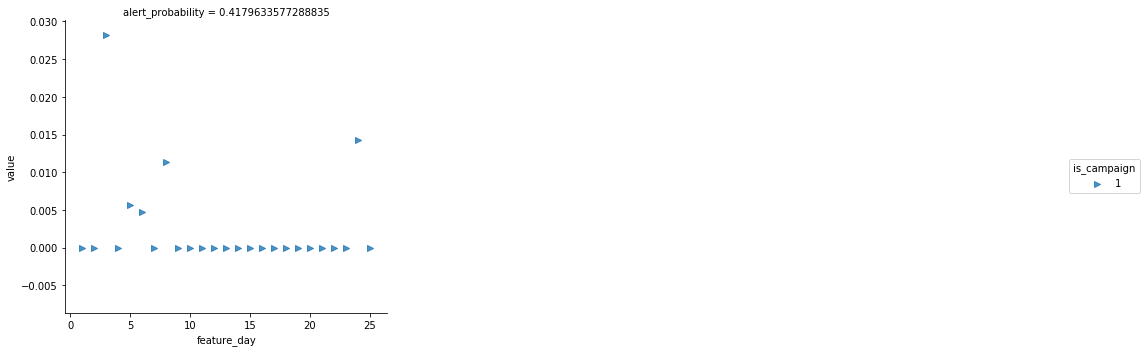

---------------------------------------
| Plotting the FN data.
---------------------------------------
| FN on KPI = tac
---------------------------------------


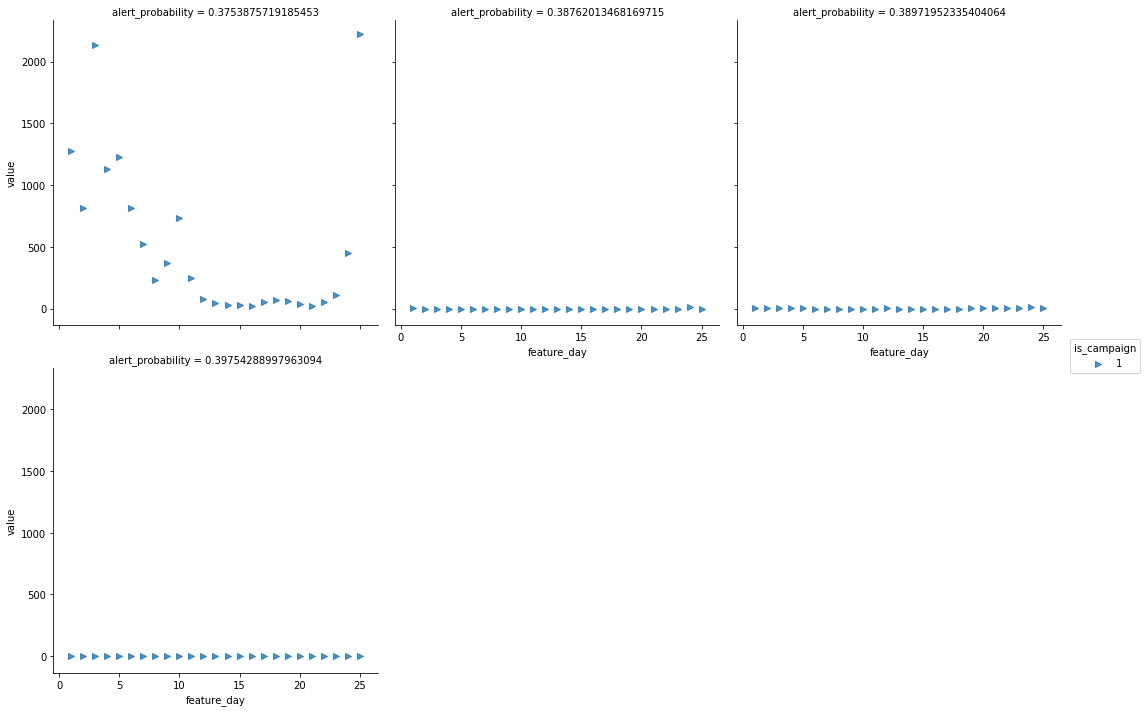

---------------------------------------
| FN on KPI = displays
---------------------------------------


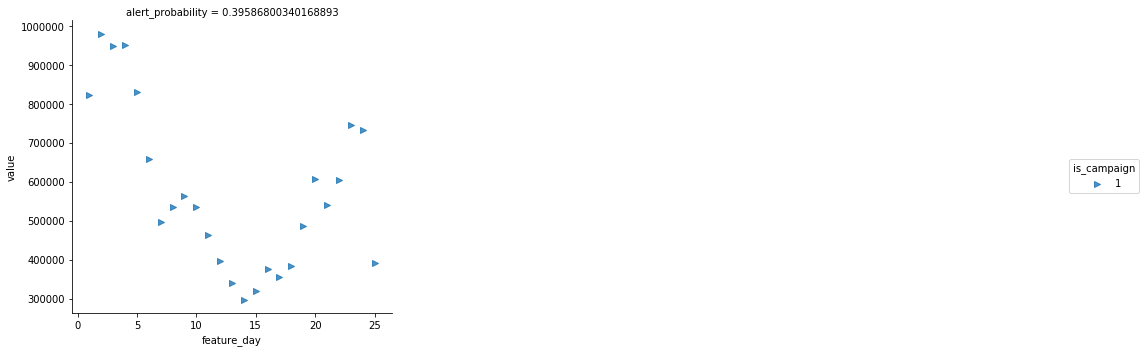

---------------------------------------
| FN on KPI = cr
---------------------------------------


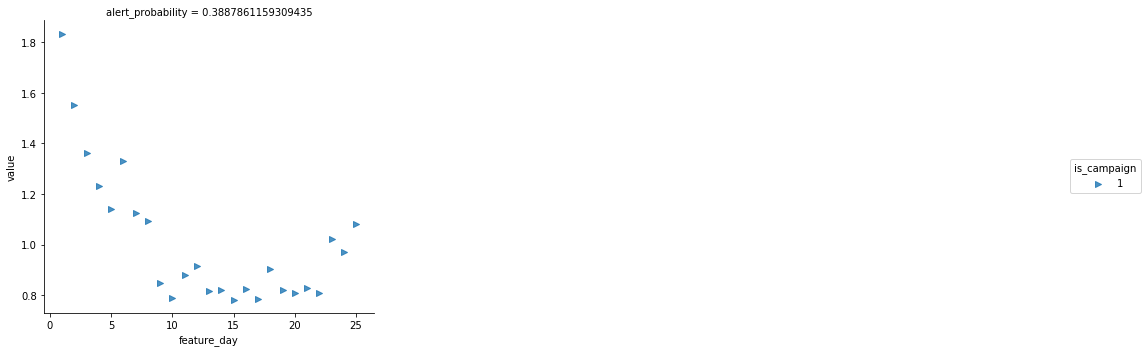

---------------------------------------
| FN on KPI = conversions
---------------------------------------


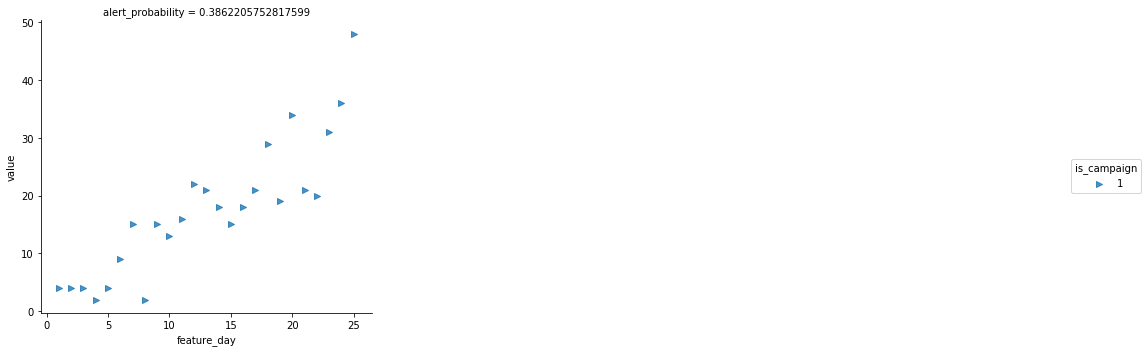

---------------------------------------
| FN on KPI = clicks
---------------------------------------


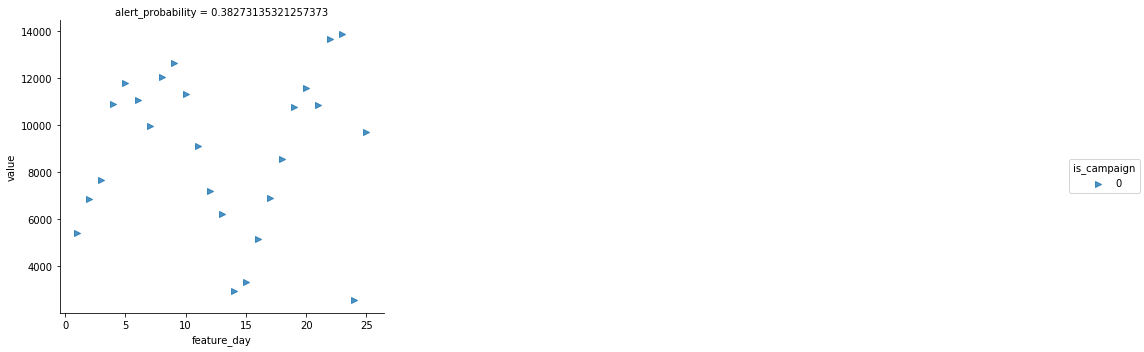

---------------------------------------
| FN on KPI = cos
---------------------------------------


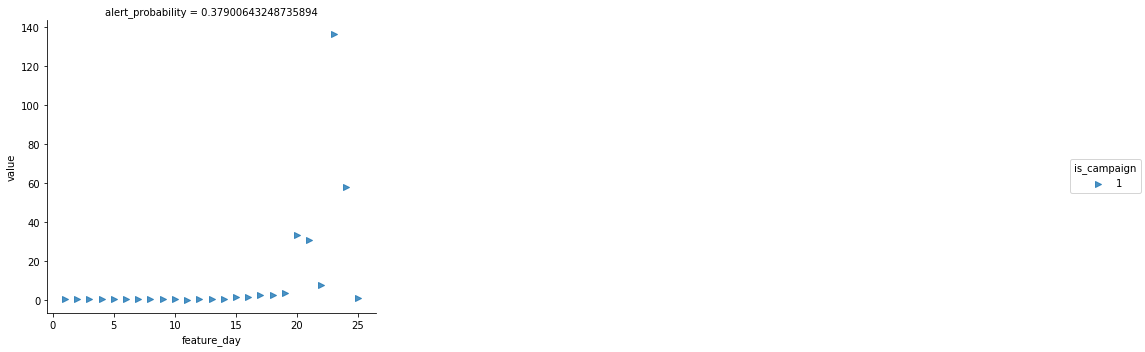

---------------------------------------
| FN on KPI = order_value
---------------------------------------


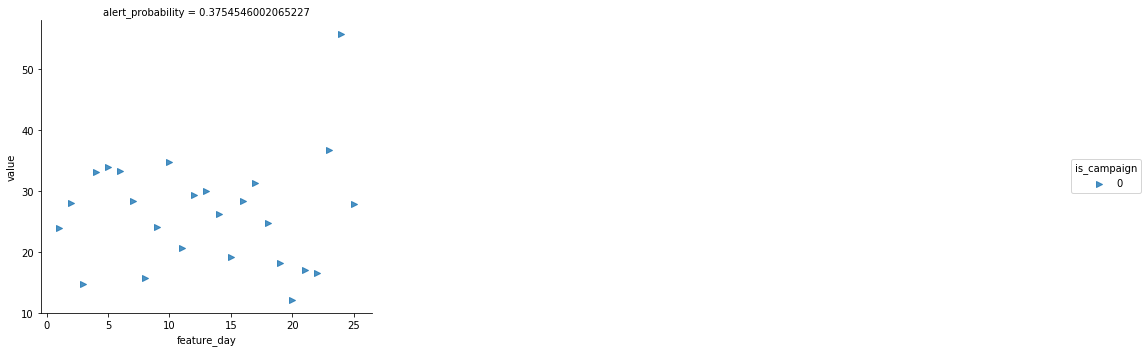

In [44]:
# show the mismatch graphs for the top ten
utils.mismatched_graphs(AS_log_reg_mismatches, 'AS')

In [45]:
# show the mismatch counts for the top ten
utils.mismatched_analysis(TS_log_reg_mismatches, 'TS')

kpi,site_events,tag_events
result,,
FN,3,7
FP,0,1


---------------------------------------
| Plotting the FP data.
---------------------------------------
| FP on KPI = tag_events
---------------------------------------


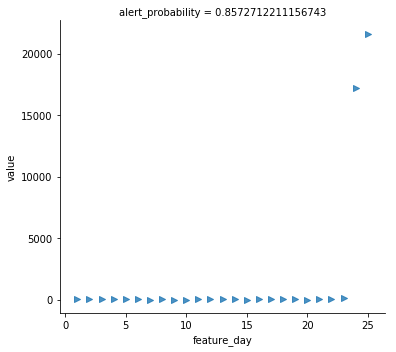

---------------------------------------
| Plotting the FN data.
---------------------------------------
| FN on KPI = tag_events
---------------------------------------


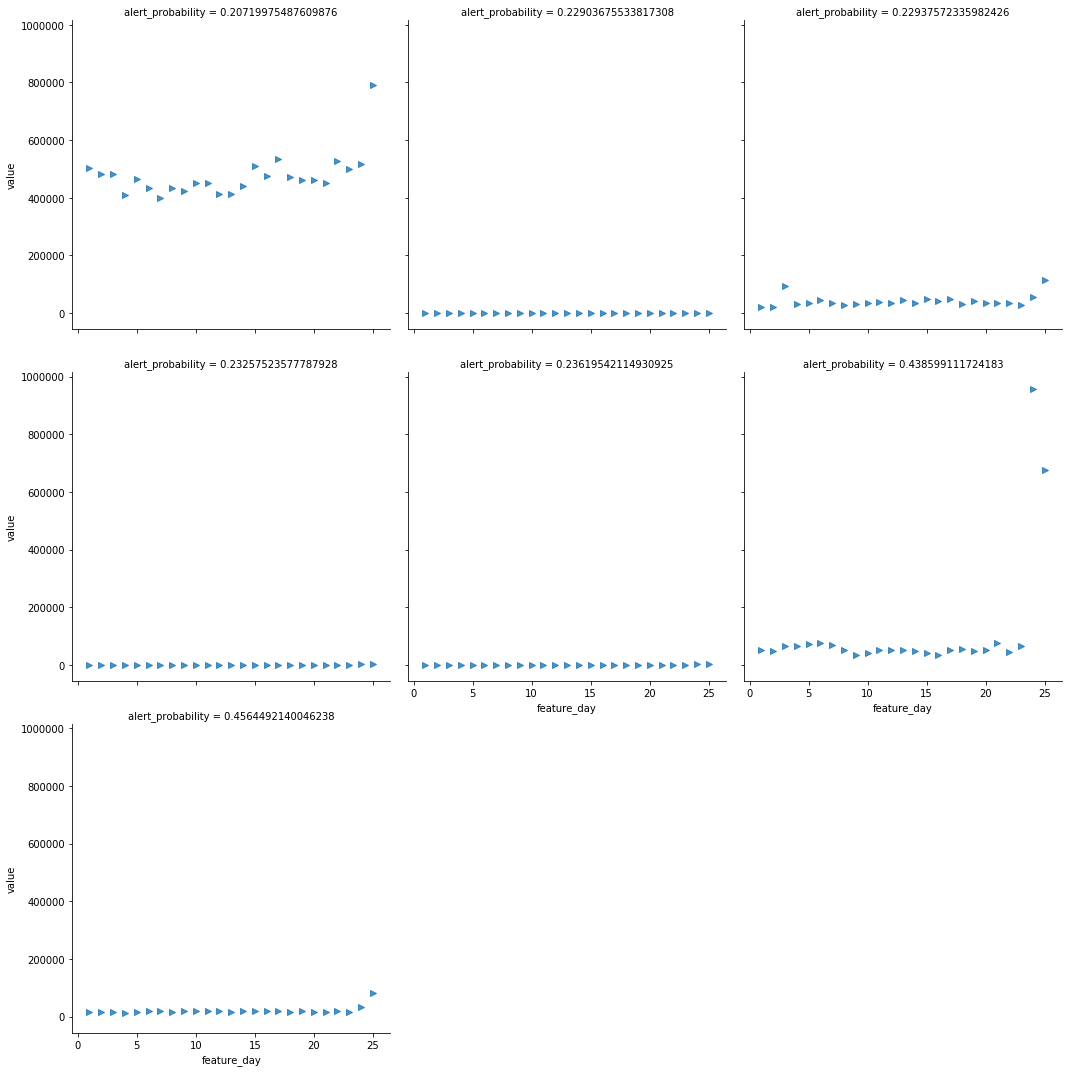

---------------------------------------
| FN on KPI = site_events
---------------------------------------


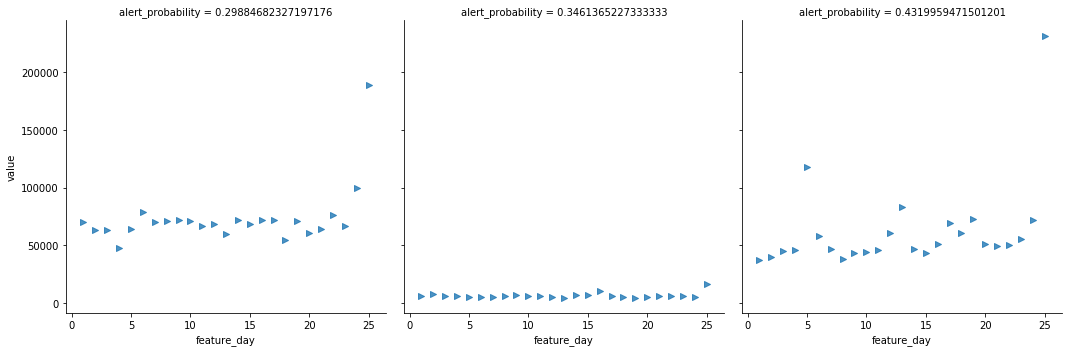

In [46]:
# show the mismatch graphs for the top ten
utils.mismatched_graphs(TS_log_reg_mismatches, 'TS')

In [47]:
# show the mismatch counts for the top ten
utils.mismatched_analysis(RexT_log_reg_mismatches, 'RexT')

series,ARGENTINA,CHILE,LATAM
result,,,
FN,1,2,1
FP,0,0,1


---------------------------------------
| Plotting the FP data.
---------------------------------------
| FP on KPI = territory_rext
---------------------------------------


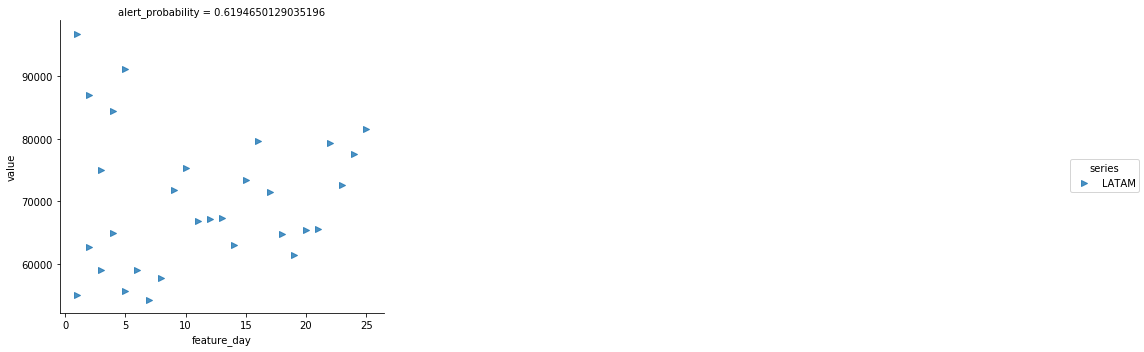

---------------------------------------
| Plotting the FN data.
---------------------------------------
| FN on KPI = territory_rext
---------------------------------------


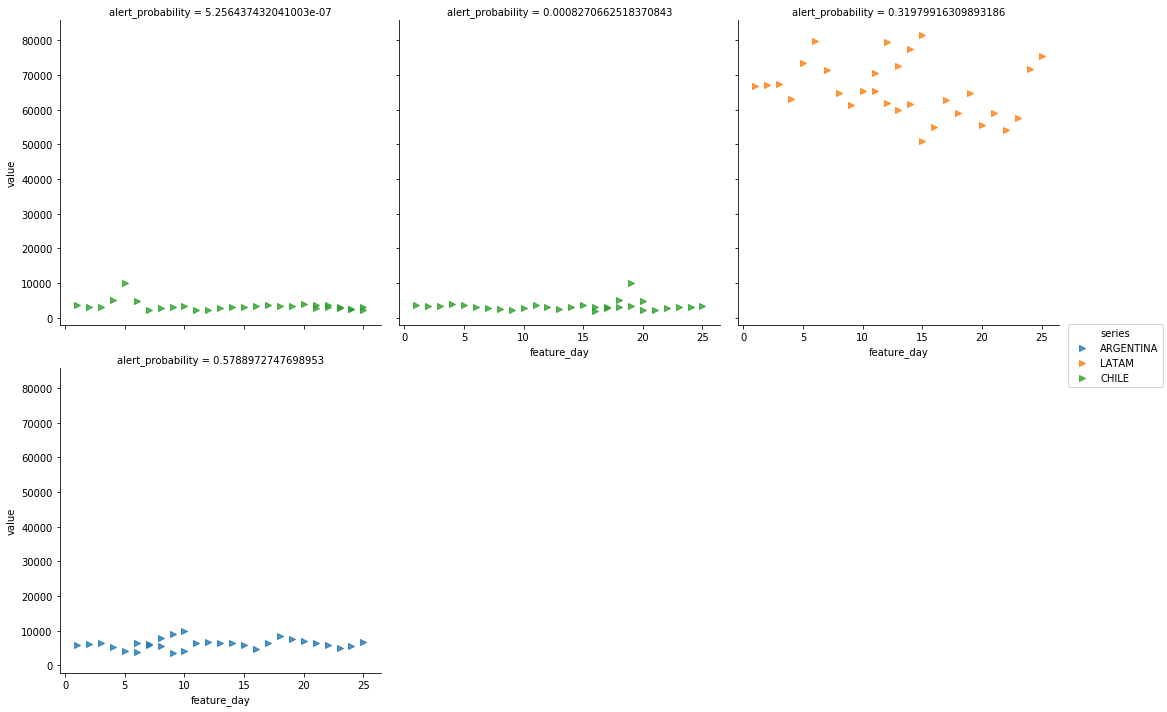

In [48]:
# show the mismatch graphs for the top ten
utils.mismatched_graphs(RexT_log_reg_mismatches, 'RexT')

### Logistic Regression with Differences

In [42]:
%%capture 
# ^ don't print errors about precision, recall, F1-score being 0

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, fbeta_score, zero_one_loss, cohen_kappa_score

logistic_regression = LogisticRegression(penalty='l2', tol=0.0001, C=1.0, 
                                         fit_intercept=True, random_state=42, 
                                         max_iter=100, verbose=0, n_jobs=-1)
parameters = {'penalty' : ('l2', 'l1'),
              'C':[i/10 for i in range(11) if i > 0],
#              'fit_intercept' : [True, False],
             'class_weight' : ['balanced', None],
             'intercept_scaling' : [0.5, 1, 1.5, 2, 2.5, 3]}

scoring = {'auc': 'roc_auc',
           # only reports on alerts flagged
           'precision_binary' : make_scorer(precision_score, average='binary'), 
           # global count of everything like confusion matrix
           'precision_micro' : make_scorer(precision_score, average='micro'), 
           # metrics calculated for each label and averaged evenly (regardless of class size)
#            'precision_macro' : make_scorer(precision_score, average='macro'), 
           # same as macro but with a weighted average to account for imbalance of the classes
           'precision_weighted' : make_scorer(precision_score, average='weighted'),
          'recall_weighted' : make_scorer(recall_score, average='weighted'),
          'recall_binary' : make_scorer(recall_score, average='binary'),
          'recall_micro' : make_scorer(recall_score, average='micro'),
#           'recall_macro' : make_scorer(recall_score, average='macro'),
          'f1_score_weighted' : make_scorer(f1_score, average='weighted'),
          'f1_score_binary' : make_scorer(f1_score, average='binary'),
          'f1_score_micro' : make_scorer(f1_score, average='micro'),
#           'f1_score_macro' : make_scorer(f1_score, average='macro'),
           # emphasize recall more
          'f2_score_weighted' : make_scorer(fbeta_score, beta=2, average='weighted'), 
          'f2_score_binary' : make_scorer(fbeta_score, beta=2, average='binary'),
          'f2_score_micro' : make_scorer(fbeta_score, beta=2, average='micro'),
#           'f2_score_macro' : make_scorer(fbeta_score, beta=2, average='macro'),
           # emphasize precision more
          'f0.5_score_weighted' : make_scorer(fbeta_score, beta=0.5, average='weighted'), 
          'f0.5_score_binary' : make_scorer(fbeta_score, beta=0.5, average='binary'),
          'f0.5_score_micro' : make_scorer(fbeta_score, beta=0.5, average='micro'),
#           'f0.5_score_macro' : make_scorer(fbeta_score, beta=0.5, average='macro'),
           # percent of misclassifications
          'zero_one_loss_normalized' : make_scorer(zero_one_loss, greater_is_better=False), 
           # number of misclassifications
          'zero_one_loss_count' : make_scorer(zero_one_loss, greater_is_better=False, 
                                              normalize=False), 
           'kappa' : make_scorer(cohen_kappa_score),
          'accuracy' : 'accuracy'}

# pick '_weighted' if you want to be right on each class proportionally 
# ('macro' isn't really appropriate due to the class imbalance)
# pick '_binary' if you want to perform best on the alert class
# pick '_micro' to count globally all TP, FP, TN, FN (like confusion matrix)
# so for our purposes 'f1_score' with one of the above is likely to be the best
refit_AS = 'precision_binary'
refit_TS = 'precision_binary'
refit_RexT = 'auc'

AS_logistic_grid = GridSearchCV(estimator=logistic_regression, param_grid=parameters, 
                                scoring=scoring, refit=refit_AS, return_train_score=True)
TS_logistic_grid = GridSearchCV(estimator=logistic_regression, param_grid=parameters, 
                                scoring=scoring, refit=refit_TS, return_train_score=True)
RexT_logistic_grid = GridSearchCV(estimator=logistic_regression, param_grid=parameters, 
                                  scoring=scoring, refit=refit_RexT, return_train_score=True)

# fit the models to find the best version
AS_logistic_regression_model_diff = AS_logistic_grid.fit(AS_X_train_diff, AS_y_train_diff)
TS_logistic_regression_model_diff = TS_logistic_grid.fit(TS_X_train_diff, TS_y_train_diff)
RexT_logistic_regression_model_diff = RexT_logistic_grid.fit(RexT_X_train_diff, RexT_y_train_diff)

#### Best Logistic Regression Models
##### AS
The model seems to pick up that the most important features are whether or not it is a campaign, the 5 most recent dates (time_delta's 1-5). TAC, margin, and RexT euro have very negative coefficients most likely because we don't see many alerts there so the log odds are small and the exponential of those values is near 0. Clicks, displays, and spend are more likely.

In [43]:
print(AS_logistic_regression_model_diff.best_estimator_)
print(refit_AS + ' (Mean cross-validated score of the best_estimator): ' + \
      str(AS_logistic_regression_model_diff.best_score_))
for col, coef in zip(AS_X_train_diff.columns, AS_logistic_regression_model_diff.best_estimator_.coef_[0]):
    print(col + '\t' + str(round(coef, 2)))

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=2, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
precision_binary (Mean cross-validated score of the best_estimator): 0.6839052912726485
is_campaign	0.14
time_delta_01	0.26
time_delta_02	0.14
time_delta_03	0.05
time_delta_04	0.02
time_delta_05	0.01
time_delta_06	0.08
time_delta_07	0.0
time_delta_08	0.0
time_delta_09	0.0
time_delta_10	0.0
time_delta_11	0.0
time_delta_12	0.0
time_delta_13	0.0
time_delta_14	0.0
time_delta_15	0.0
time_delta_16	0.0
time_delta_17	0.0
time_delta_18	0.0
time_delta_19	0.0
time_delta_20	0.0
time_delta_21	0.0
time_delta_22	0.0
time_delta_23	0.0
time_delta_24	0.0
time_delta_25	0.0
kpi_clicks	0.0
kpi_client_rext	0.0
kpi_conversions	0.0
kpi_cos	0.0
kpi_cr	0.0
kpi_ctr	0.0
kpi_displays	0.0
kpi_margin	-1.3
kpi_order_value	0.0
kpi_rext_euro	-0.93
kpi_spend	0.

##### TS

In [44]:
print(TS_logistic_regression_model_diff.best_estimator_)
print(refit_TS + ' (Mean cross-validated score of the best_estimator): ' + \
      str(TS_logistic_regression_model_diff.best_score_))
for col, coef in zip(TS_X_train_diff.columns, TS_logistic_regression_model_diff.best_estimator_.coef_[0]):
    print(col + '\t' + str(round(coef, 2)))

LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
precision_binary (Mean cross-validated score of the best_estimator): 0.8690518967198808
time_delta_01	2.52
time_delta_02	0.0
time_delta_03	0.0
time_delta_04	0.0
time_delta_05	0.0
time_delta_06	0.0
time_delta_07	0.0
time_delta_08	0.0
time_delta_09	0.0
time_delta_10	0.0
time_delta_11	0.0
time_delta_12	0.0
time_delta_13	0.0
time_delta_14	0.0
time_delta_15	0.0
time_delta_16	0.0
time_delta_17	0.0
time_delta_18	0.0
time_delta_19	0.0
time_delta_20	0.0
time_delta_21	0.0
time_delta_22	0.0
time_delta_23	0.0
time_delta_24	0.0
time_delta_25	0.0
site_type_SITE LEVEL	0.0
site_type_aa	0.0
site_type_aios	0.0
site_type_d	-0.51
site_type_m	0.09
site_type_t	0.0
event_name_basket	0.0
event_name_homepage	0.0
event_name_listing	0.0
event_name_produ

##### RexT

In [45]:
print(RexT_logistic_regression_model_diff.best_estimator_)
print(refit_RexT + ' (Mean cross-validated score of the best_estimator): ' + \
      str(RexT_logistic_regression_model_diff.best_score_))
for col, coef in zip(RexT_X_train_diff.columns, RexT_logistic_regression_model_diff.best_estimator_.coef_[0]):
    print(col + '\t' + str(round(coef, 2)))

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=3, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
auc (Mean cross-validated score of the best_estimator): 0.9888888888888889
time_delta_01	1.26
time_delta_02	0.0
time_delta_03	0.0
time_delta_04	0.0
time_delta_05	0.0
time_delta_06	0.0
time_delta_07	0.0
time_delta_08	0.0
time_delta_09	0.0
time_delta_10	0.0
time_delta_11	0.0
time_delta_12	0.0
time_delta_13	0.0
time_delta_14	0.0
time_delta_15	0.0
time_delta_16	0.0
time_delta_17	0.0
time_delta_18	0.0
time_delta_19	0.0
time_delta_20	0.0
time_delta_21	0.0
time_delta_22	0.0
time_delta_23	0.0
time_delta_24	0.0
time_delta_25	0.0
time_delta_26	0.0
time_delta_27	0.0
time_delta_28	0.0
time_delta_29	0.0
time_delta_30	0.0
time_delta_diff_29	0.0
time_delta_diff_28	0.0
time_delta_diff_27	0.0
time_delta_diff_26	0.0
time_delta_diff_25	0.0
time_

#### Model Evaluation
##### ROC Curve

In [46]:
from sklearn.metrics import roc_curve, auc

AS_y_prob_fit_diff = AS_logistic_regression_model_diff.predict_proba(AS_X_test_diff)
TS_y_prob_fit_diff = TS_logistic_regression_model_diff.predict_proba(TS_X_test_diff)
RexT_y_prob_fit_diff = RexT_logistic_regression_model_diff.predict_proba(RexT_X_test_diff)

AS_logistic_reg_roc_curve_diff = roc_curve(AS_y_test_diff, AS_y_prob_fit_diff[:,1], 
                                           pos_label=1) # returns tuple: fpr, tpr, thresholds
AS_logistic_reg_roc_curve_AUC_diff = auc(AS_logistic_reg_roc_curve_diff[0], 
                                        AS_logistic_reg_roc_curve_diff[1]) # needs fpr, tpr
TS_logistic_reg_roc_curve_diff = roc_curve(TS_y_test_diff, TS_y_prob_fit_diff[:,1], pos_label=1)
TS_logistic_reg_roc_curve_AUC_diff = auc(TS_logistic_reg_roc_curve_diff[0], 
                                        TS_logistic_reg_roc_curve_diff[1])
RexT_logistic_reg_roc_curve_diff = roc_curve(RexT_y_test_diff, RexT_y_prob_fit_diff[:,1], pos_label=1)
RexT_logistic_reg_roc_curve_AUC_diff = auc(RexT_logistic_reg_roc_curve_diff[0], 
                                          RexT_logistic_reg_roc_curve_diff[1])

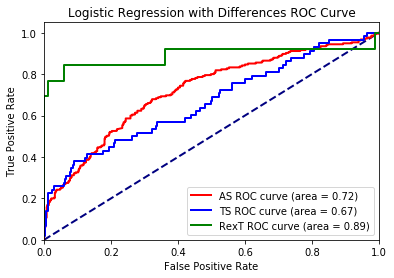

In [47]:
# ROC Curve
utils.model_roc_curves(roc_data_dict={'AS' : AS_logistic_reg_roc_curve_diff, 
                                'TS' : TS_logistic_reg_roc_curve_diff, 
                                'RexT' : RexT_logistic_reg_roc_curve_diff}, 
                 auc_dict={'AS' : AS_logistic_reg_roc_curve_AUC_diff, 
                           'TS' : TS_logistic_reg_roc_curve_AUC_diff, 
                           'RexT' : RexT_logistic_reg_roc_curve_AUC_diff}, 
                 method_name='Logistic Regression with Differences')

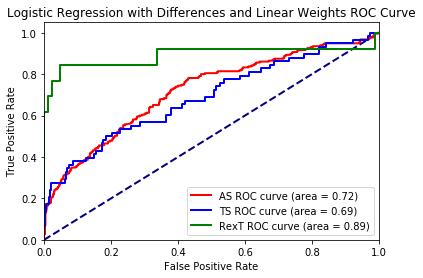

In [54]:
# ROC Curve
utils.model_roc_curves(roc_data_dict={'AS' : AS_logistic_reg_roc_curve_diff, 
                                'TS' : TS_logistic_reg_roc_curve_diff, 
                                'RexT' : RexT_logistic_reg_roc_curve_diff}, 
                 auc_dict={'AS' : AS_logistic_reg_roc_curve_AUC_diff, 
                           'TS' : TS_logistic_reg_roc_curve_AUC_diff, 
                           'RexT' : RexT_logistic_reg_roc_curve_AUC_diff}, 
                 method_name='Logistic Regression with Differences and Linear Weights')

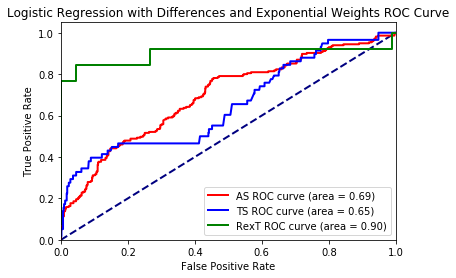

In [46]:
# ROC Curve
utils.model_roc_curves(roc_data_dict={'AS' : AS_logistic_reg_roc_curve_diff, 
                                'TS' : TS_logistic_reg_roc_curve_diff, 
                                'RexT' : RexT_logistic_reg_roc_curve_diff}, 
                 auc_dict={'AS' : AS_logistic_reg_roc_curve_AUC_diff, 
                           'TS' : TS_logistic_reg_roc_curve_AUC_diff, 
                           'RexT' : RexT_logistic_reg_roc_curve_AUC_diff}, 
                 method_name='Logistic Regression with Differences and Exponential Weights')

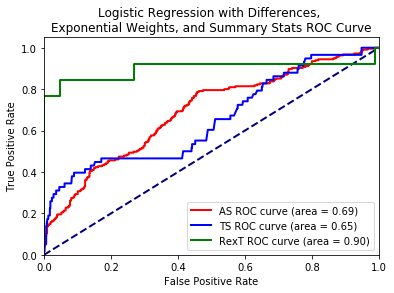

In [35]:
# ROC Curve
utils.model_roc_curves(roc_data_dict={'AS' : AS_logistic_reg_roc_curve_diff, 
                                'TS' : TS_logistic_reg_roc_curve_diff, 
                                'RexT' : RexT_logistic_reg_roc_curve_diff}, 
                 auc_dict={'AS' : AS_logistic_reg_roc_curve_AUC_diff, 
                           'TS' : TS_logistic_reg_roc_curve_AUC_diff, 
                           'RexT' : RexT_logistic_reg_roc_curve_AUC_diff}, 
                 method_name='Logistic Regression with Differences, \nExponential Weights, and Summary Stats')

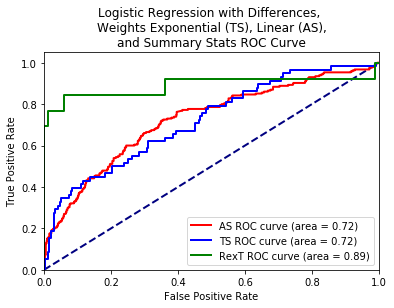

In [47]:
# ROC Curve
utils.model_roc_curves(roc_data_dict={'AS' : AS_logistic_reg_roc_curve_diff, 
                                'TS' : TS_logistic_reg_roc_curve_diff, 
                                'RexT' : RexT_logistic_reg_roc_curve_diff}, 
                 auc_dict={'AS' : AS_logistic_reg_roc_curve_AUC_diff, 
                           'TS' : TS_logistic_reg_roc_curve_AUC_diff, 
                           'RexT' : RexT_logistic_reg_roc_curve_AUC_diff}, 
                 method_name='Logistic Regression with Differences, \nWeights Exponential (TS), Linear (AS),\nand Summary Stats')

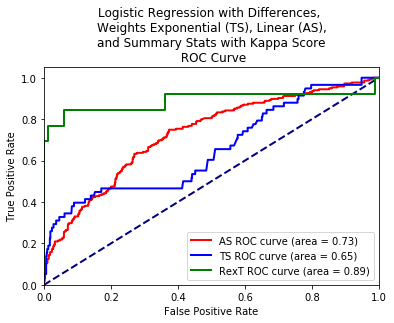

In [262]:
# ROC Curve
utils.model_roc_curves(roc_data_dict={'AS' : AS_logistic_reg_roc_curve_diff, 
                                'TS' : TS_logistic_reg_roc_curve_diff, 
                                'RexT' : RexT_logistic_reg_roc_curve_diff}, 
                 auc_dict={'AS' : AS_logistic_reg_roc_curve_AUC_diff, 
                           'TS' : TS_logistic_reg_roc_curve_AUC_diff, 
                           'RexT' : RexT_logistic_reg_roc_curve_AUC_diff}, 
                 method_name='Logistic Regression with Differences, \nWeights Exponential (TS), Linear (AS),\nand Summary Stats with Kappa Score\n')

##### Check Alert Counts at Certain Threshold

In [48]:
utils.threshold_results(AS_logistic_regression_model_diff.predict_proba(AS_X_test_diff),
                  TS_logistic_regression_model_diff.predict_proba(TS_X_test_diff),
                  RexT_logistic_regression_model_diff.predict_proba(RexT_X_test_diff))

0% threshold
AS alert count: 990
TS alert count: 696
RexT alert count: 99
---------------------------------------------------------
10% threshold
AS alert count: 805
TS alert count: 110
RexT alert count: 21
---------------------------------------------------------
20% threshold
AS alert count: 464
TS alert count: 16
RexT alert count: 9
---------------------------------------------------------
30% threshold
AS alert count: 197
TS alert count: 5
RexT alert count: 7
---------------------------------------------------------
40% threshold
AS alert count: 67
TS alert count: 2
RexT alert count: 5
---------------------------------------------------------
50% threshold
AS alert count: 30
TS alert count: 2
RexT alert count: 2
---------------------------------------------------------
60% threshold
AS alert count: 14
TS alert count: 2
RexT alert count: 1
---------------------------------------------------------
70% threshold
AS alert count: 5
TS alert count: 0
RexT alert count: 1
-----------------

##### Confusion Matrix

TP to FP ratio: 2.67


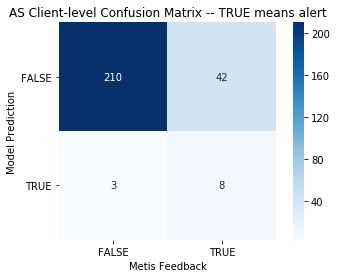

TP to FP ratio: 1.67


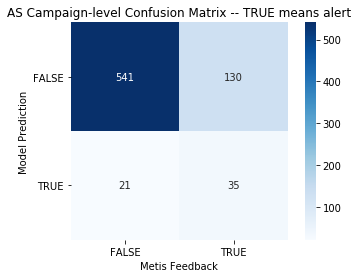

TP to FP ratio: 1.67


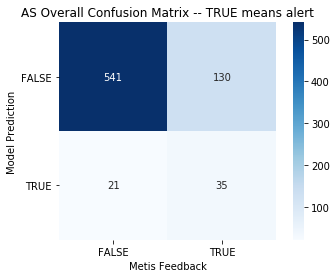

In [49]:
AS_threshold = 0.4
utils.confusion_matrix_visual(AS_y_test_diff[AS_X_test_diff.is_campaign == 0], 
                        AS_logistic_regression_model_diff.predict_proba(AS_X_test_diff[AS_X_test_diff.is_campaign == 0])[:,1] \
                        >= AS_threshold, 'AS Client-level')
utils.confusion_matrix_visual(AS_y_test_diff[AS_X_test_diff.is_campaign == 1], 
                        AS_logistic_regression_model_diff.predict_proba(AS_X_test_diff[AS_X_test_diff.is_campaign == 1])[:,1] \
                        >= AS_threshold, 'AS Campaign-level')
utils.confusion_matrix_visual(AS_y_test_diff[AS_X_test_diff.is_campaign == 1], 
                        AS_logistic_regression_model_diff.predict_proba(AS_X_test_diff[AS_X_test_diff.is_campaign == 1])[:,1] \
                        >= AS_threshold, 'AS Overall')

TP to FP ratio: 0.6


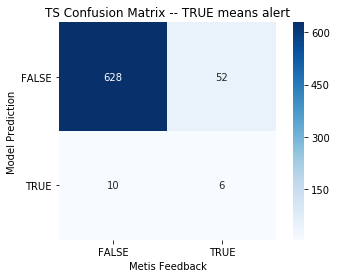

In [50]:
TS_threshold = 0.2
utils.confusion_matrix_visual(TS_y_test_diff, 
                        TS_logistic_regression_model_diff.predict_proba(TS_X_test_diff)[:,1] \
                        >= TS_threshold,
                        'TS')

TP to FP ratio: 10.0


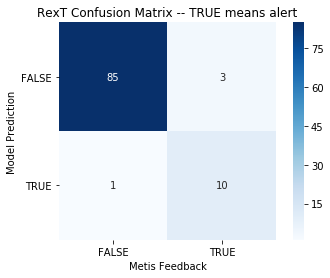

In [51]:
RexT_threshold = 0.17
utils.confusion_matrix_visual(RexT_y_test_diff, 
                        RexT_logistic_regression_model_diff.predict_proba(RexT_X_test_diff)[:,1] \
                        >= RexT_threshold,
                        'RexT')

On disqualified data.

TP to FP ratio: 0.84


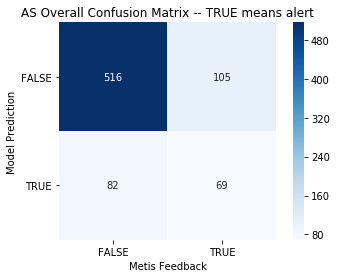

In [52]:
utils.confusion_matrix_visual(disqualified_AS['min_max']['is_alert'], 
                        AS_logistic_regression_model_diff.predict_proba(disqualified_AS['min_max'].\
                                                                   drop([col for col in disqualified_AS['min_max'].columns
                                                                        if col in ['run_date', 'series', 'is_alert']], axis=1))[:,1] \
                        >= AS_threshold, 'AS Overall')

TP to FP ratio: 0.5


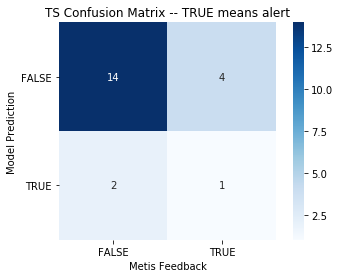

In [53]:
utils.confusion_matrix_visual(disqualified_TS['min_max']['is_alert'], 
                        TS_logistic_regression_model_diff.predict_proba(disqualified_TS['min_max'].\
                                                                   drop([col for col in disqualified_TS['min_max'].columns
                                                                        if col in ['run_date', 'series', 'is_alert']], axis=1))[:,1] \
                        >= TS_threshold,
                        'TS')

#### Metrics

In [54]:
utils.classification_report_all(y_test_dict={'AS' : AS_y_test_diff, 
                                       'TS' : TS_y_test_diff, 
                                       'RexT' : RexT_y_test_diff},
                         y_pred_dict={'AS' : 
                                      AS_logistic_regression_model_diff.predict_proba(AS_X_test_diff)[:,1] >= \
                                      AS_threshold, 
                                      'TS' : 
                                      TS_logistic_regression_model_diff.predict_proba(TS_X_test_diff)[:,1] >= \
                                      TS_threshold, 
                                      'RexT' : 
                                      RexT_logistic_regression_model_diff.predict_proba(RexT_X_test_diff)[:,1] >= \
                                      RexT_threshold})

AS results
             precision    recall  f1-score   support

      False       0.81      0.97      0.88       775
       True       0.64      0.20      0.30       215

avg / total       0.78      0.80      0.76       990

Percent misclassified: 19.8%
Count misclassified: 196
------------------------------------------------------
TS results
             precision    recall  f1-score   support

      False       0.92      0.98      0.95       638
       True       0.38      0.10      0.16        58

avg / total       0.88      0.91      0.89       696

Percent misclassified: 8.91%
Count misclassified: 62
------------------------------------------------------
RexT results
             precision    recall  f1-score   support

      False       0.97      0.99      0.98        86
       True       0.91      0.77      0.83        13

avg / total       0.96      0.96      0.96        99

Percent misclassified: 4.04%
Count misclassified: 4


#### Borderline Cases

In [62]:
%%capture

AS_log_reg_mismatches_diff = utils.borderline_case_analysis(AS_threshold, AS_y_prob_fit_diff, 
                                                       AS_X_test_diff, valid_AS[AS_scaler], AS_data, 'AS')
TS_log_reg_mismatches_diff = utils.borderline_case_analysis(TS_threshold, TS_y_prob_fit_diff, 
                                                       TS_X_test_diff, valid_TS[TS_scaler], TS_data, 'TS')
RexT_log_reg_mismatches_diff = utils.borderline_case_analysis(RexT_threshold, RexT_y_prob_fit_diff, 
                                                         RexT_X_test_diff, valid_RexT[RexT_scaler], RexT_data, 'RexT')

In [63]:
# show the mismatch counts for the top ten
utils.mismatched_analysis(AS_log_reg_mismatches_diff, 'AS')

is_campaign           0                     1                             \
kpi         client_rext cr order_value clicks client_rext conversions cr   
result                                                                     
FN                    0  1           1      2           0           1  1   
FP                    1  0           1      2           1           1  0   

is_campaign                             
kpi         displays order_value spend  
result                                  
FN                 1           2     1  
FP                 3           1     0

---------------------------------------
| Plotting the FP data.
---------------------------------------
| FP on KPI = order_value
---------------------------------------


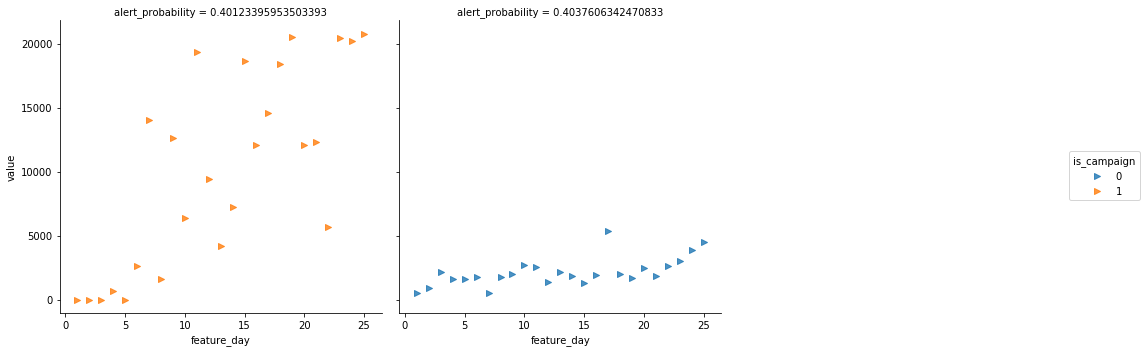

---------------------------------------
| FP on KPI = conversions
---------------------------------------


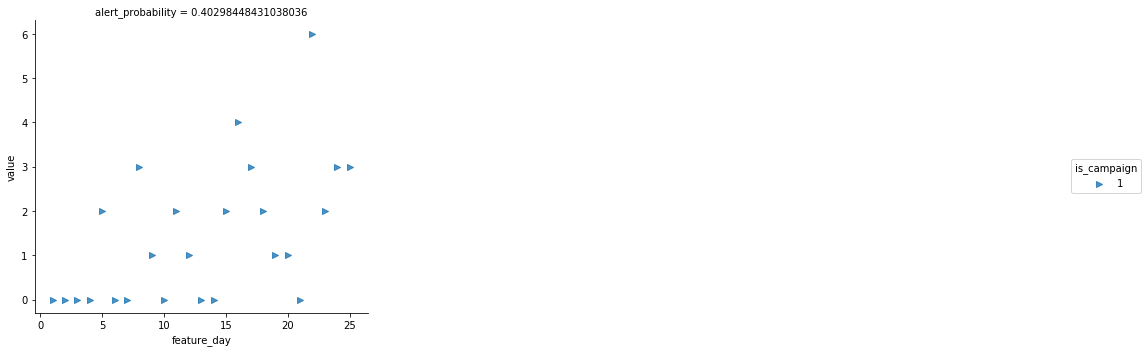

---------------------------------------
| FP on KPI = displays
---------------------------------------


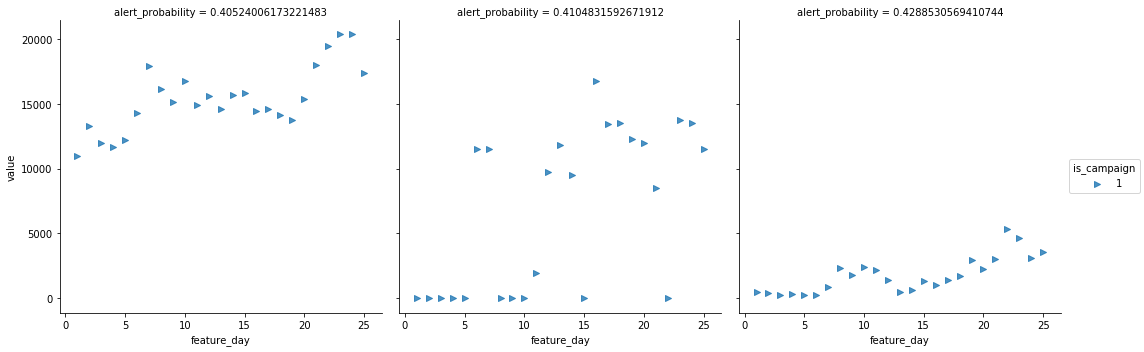

---------------------------------------
| FP on KPI = clicks
---------------------------------------


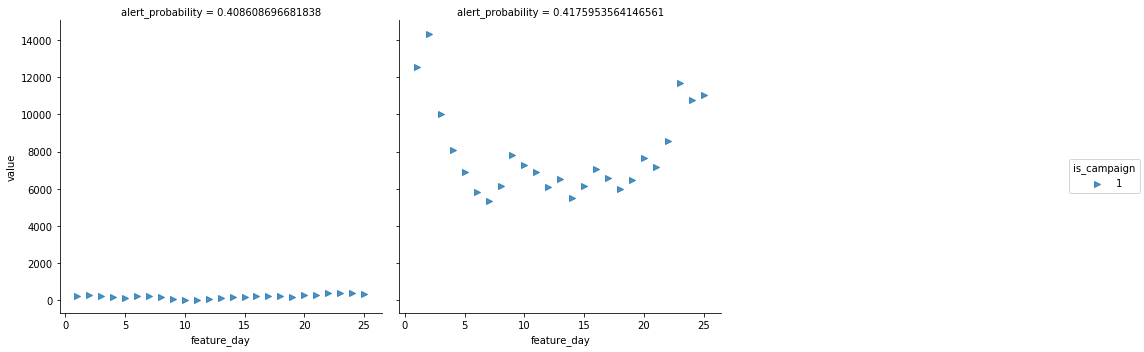

---------------------------------------
| FP on KPI = client_rext
---------------------------------------


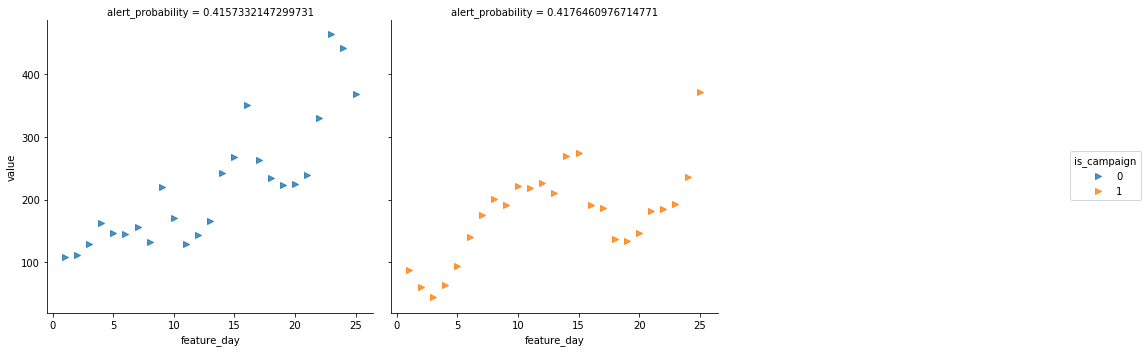

---------------------------------------
| Plotting the FN data.
---------------------------------------
| FN on KPI = cr
---------------------------------------


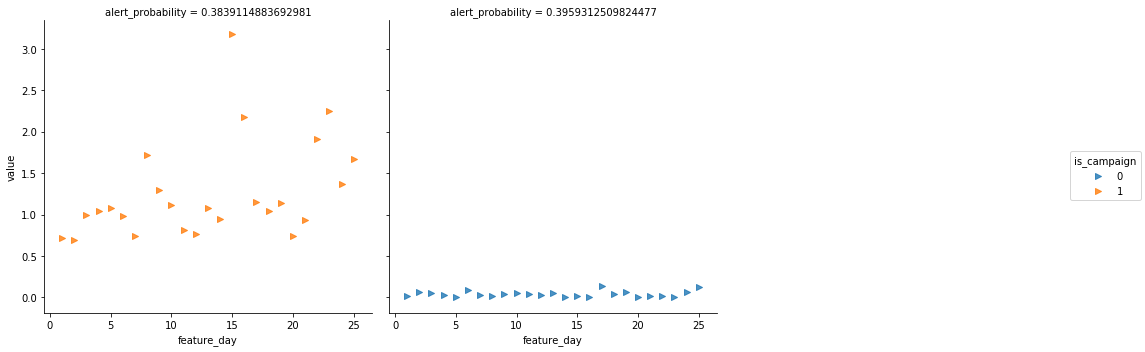

---------------------------------------
| FN on KPI = clicks
---------------------------------------


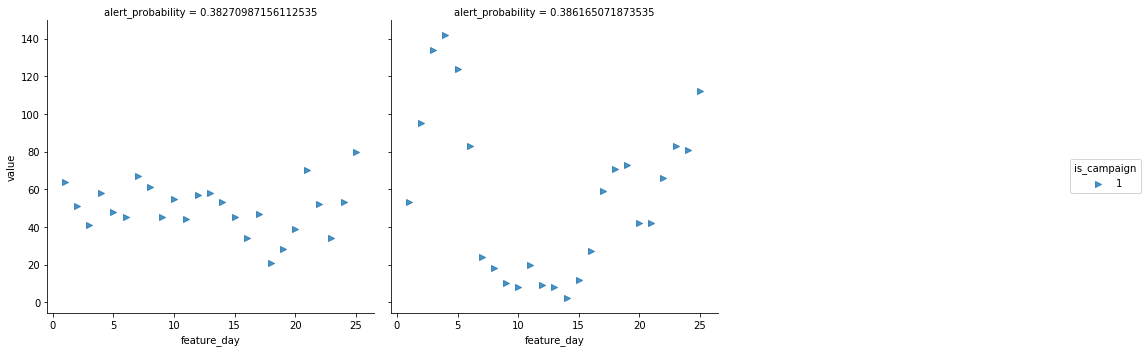

---------------------------------------
| FN on KPI = spend
---------------------------------------


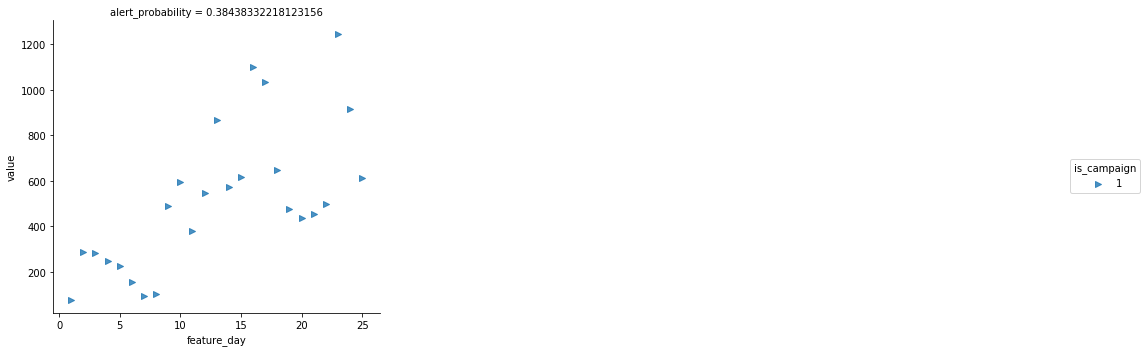

---------------------------------------
| FN on KPI = displays
---------------------------------------


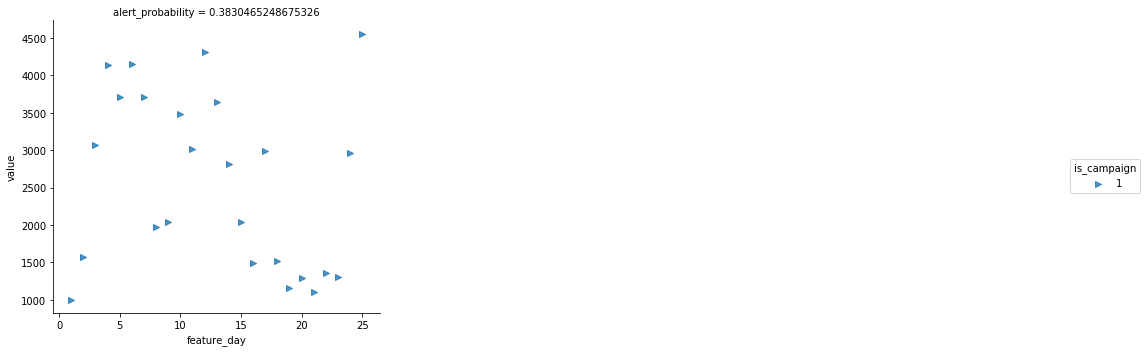

---------------------------------------
| FN on KPI = order_value
---------------------------------------


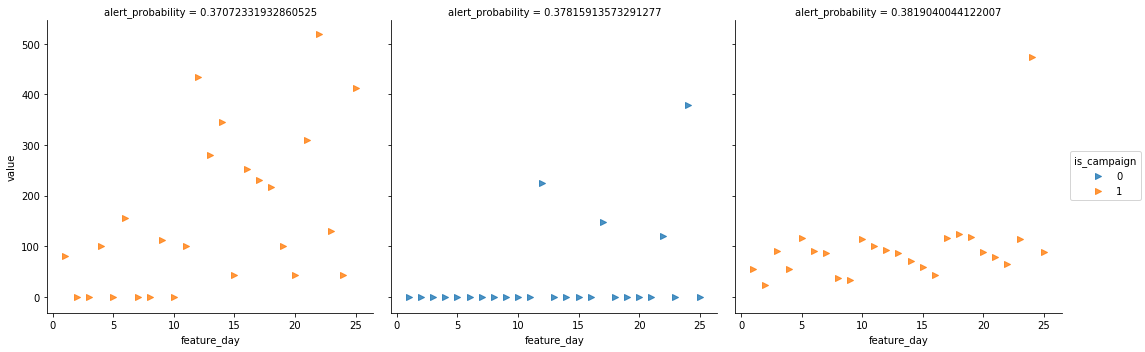

---------------------------------------
| FN on KPI = conversions
---------------------------------------


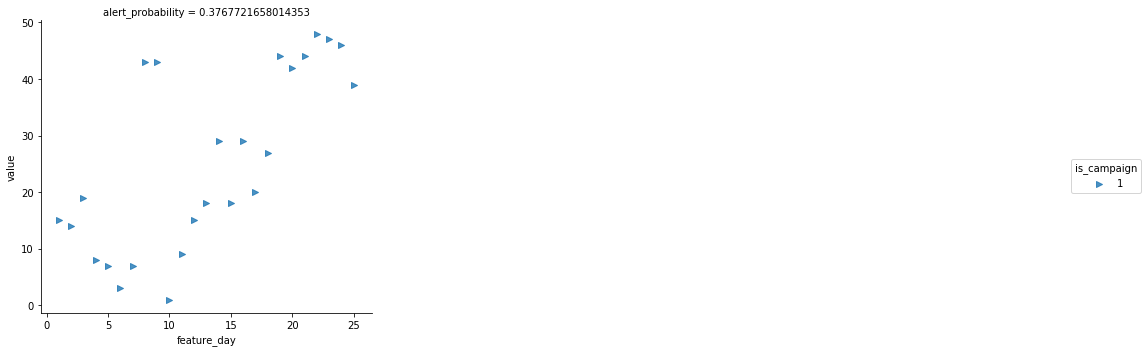

In [64]:
# show the mismatch graphs for the top ten
utils.mismatched_graphs(AS_log_reg_mismatches_diff, 'AS')

In [65]:
# show the mismatch counts for the top ten
utils.mismatched_analysis(TS_log_reg_mismatches_diff, 'TS')

kpi,site_events,tag_events
result,,
FN,1,9
FP,1,9


---------------------------------------
| Plotting the FP data.
---------------------------------------
| FP on KPI = tag_events
---------------------------------------


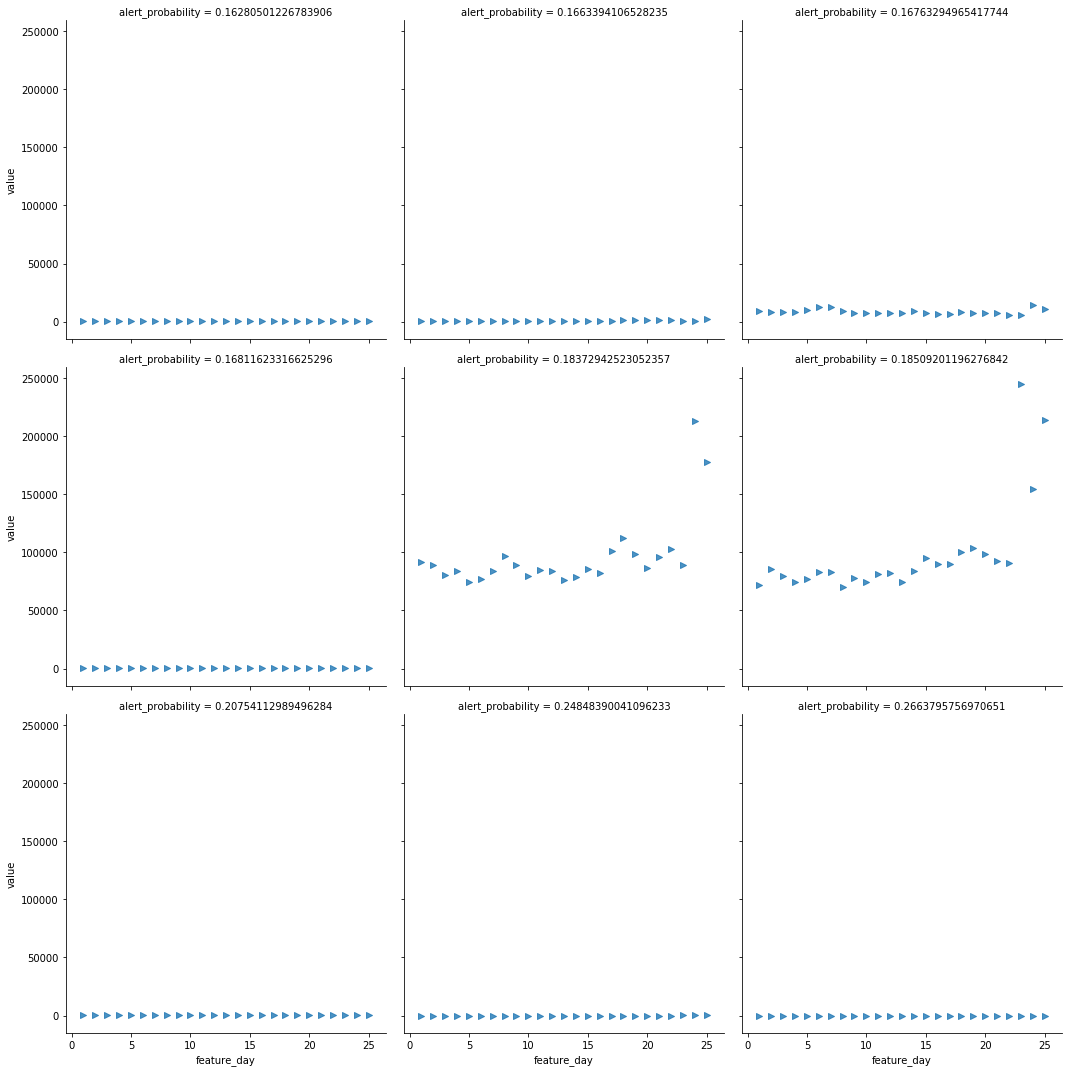

---------------------------------------
| FP on KPI = site_events
---------------------------------------


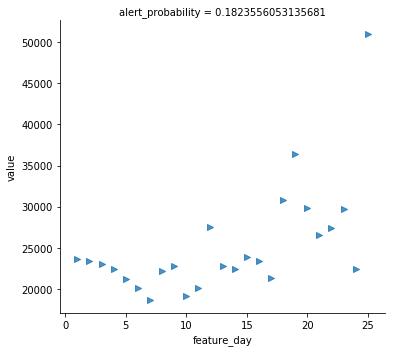

---------------------------------------
| Plotting the FN data.
---------------------------------------
| FN on KPI = tag_events
---------------------------------------


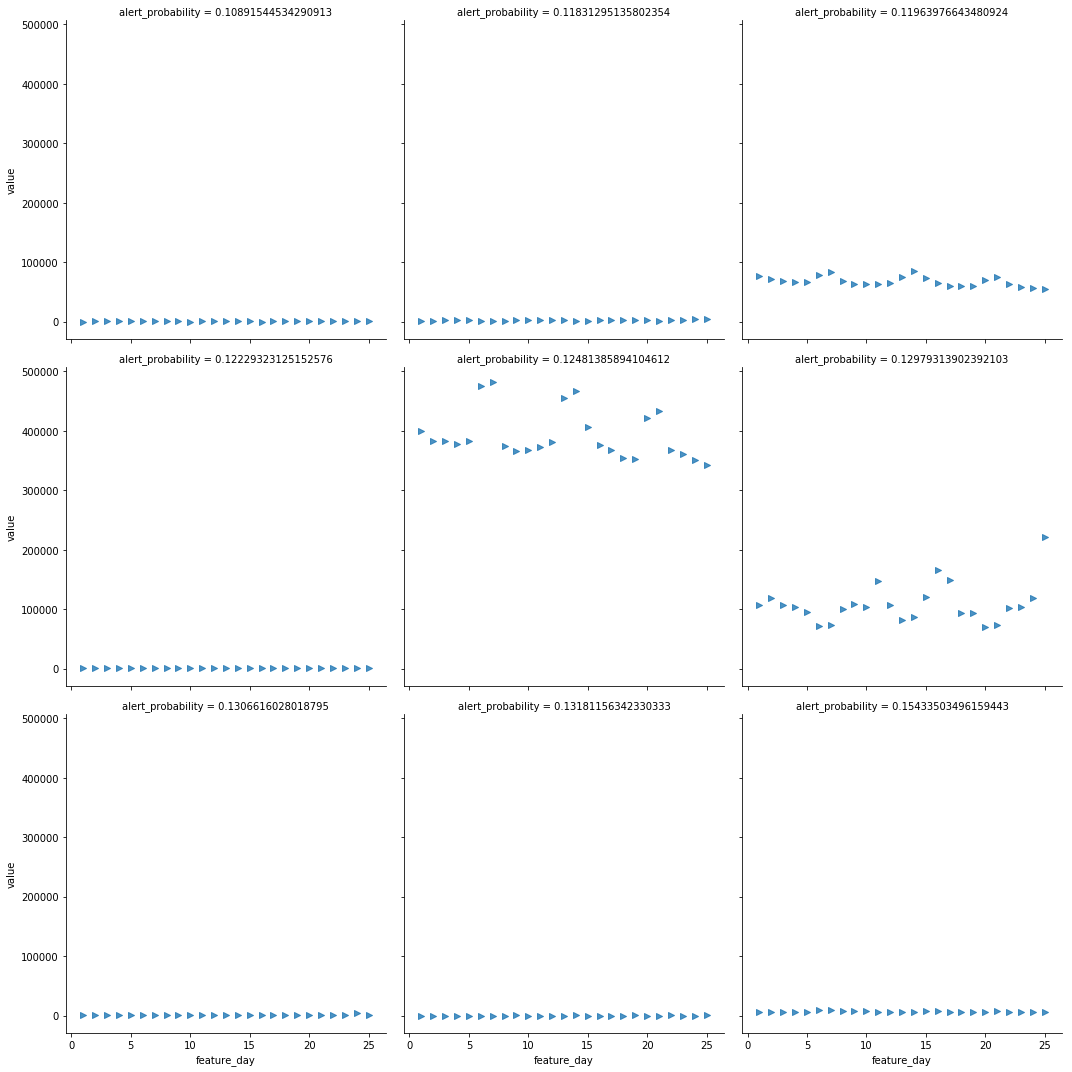

---------------------------------------
| FN on KPI = site_events
---------------------------------------


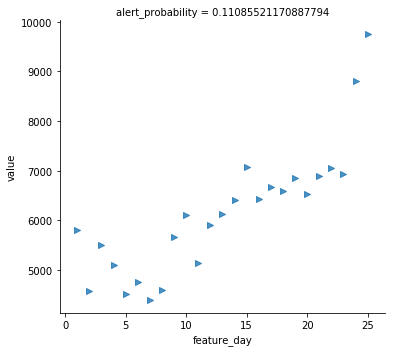

In [66]:
# show the mismatch graphs for the top ten
utils.mismatched_graphs(TS_log_reg_mismatches_diff, 'TS')

In [67]:
# show the mismatch counts for the top ten
utils.mismatched_analysis(RexT_log_reg_mismatches_diff, 'RexT')

series,CHILE,LATAM
result,,
FN,2,1
FP,0,1


---------------------------------------
| Plotting the FP data.
---------------------------------------
| FP on KPI = territory_rext
---------------------------------------


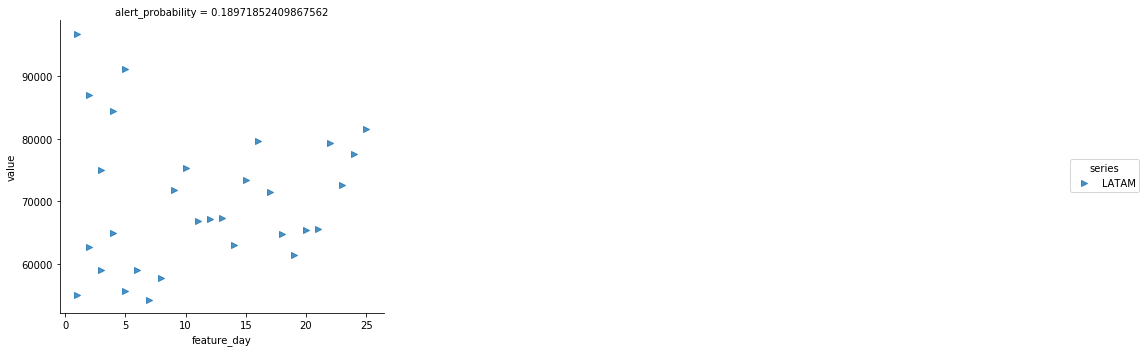

---------------------------------------
| Plotting the FN data.
---------------------------------------
| FN on KPI = territory_rext
---------------------------------------


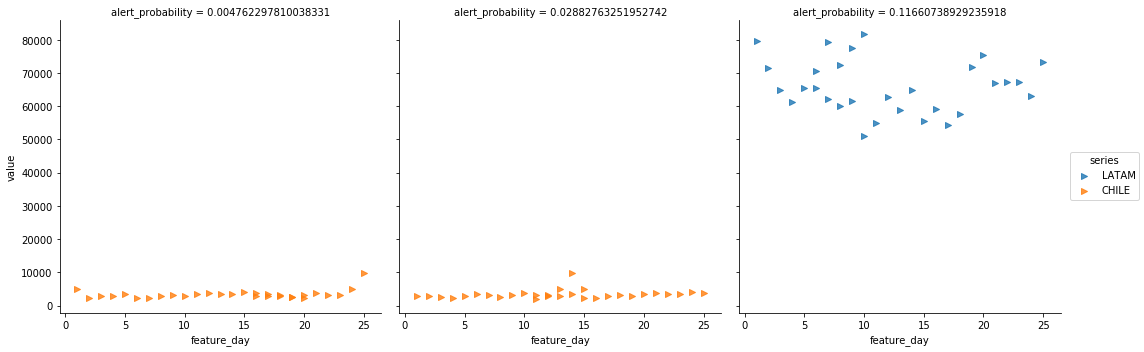

In [68]:
# show the mismatch graphs for the top ten
utils.mismatched_graphs(RexT_log_reg_mismatches_diff, 'RexT')

### Logistic Regression with Differences using "Expert" Feedback

In [55]:
%%capture 
# ^ don't print errors about precision, recall, F1-score being 0

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, fbeta_score, zero_one_loss

logistic_regression = LogisticRegression(penalty='l2', tol=0.0001, C=1.0, 
                                         fit_intercept=True, random_state=42, 
                                         max_iter=100, verbose=0, n_jobs=-1)
parameters = {'penalty' : ('l2', 'l1'),
              'C':[i/10 for i in range(11) if i > 0],
#              'fit_intercept' : [True, False],
             'class_weight' : ['balanced', None],
             'intercept_scaling' : [0.5, 1, 1.5, 2, 2.5, 3]}

scoring = {'auc': 'roc_auc',
           # only reports on alerts flagged
           'precision_binary' : make_scorer(precision_score, average='binary'), 
           # global count of everything like confusion matrix
           'precision_micro' : make_scorer(precision_score, average='micro'), 
           # metrics calculated for each label and averaged evenly (regardless of class size)
#            'precision_macro' : make_scorer(precision_score, average='macro'), 
           # same as macro but with a weighted average to account for imbalance of the classes
           'precision_weighted' : make_scorer(precision_score, average='weighted'),
          'recall_weighted' : make_scorer(recall_score, average='weighted'),
          'recall_binary' : make_scorer(recall_score, average='binary'),
          'recall_micro' : make_scorer(recall_score, average='micro'),
#           'recall_macro' : make_scorer(recall_score, average='macro'),
          'f1_score_weighted' : make_scorer(f1_score, average='weighted'),
          'f1_score_binary' : make_scorer(f1_score, average='binary'),
          'f1_score_micro' : make_scorer(f1_score, average='micro'),
#           'f1_score_macro' : make_scorer(f1_score, average='macro'),
           # emphasize recall more
          'f2_score_weighted' : make_scorer(fbeta_score, beta=2, average='weighted'), 
          'f2_score_binary' : make_scorer(fbeta_score, beta=2, average='binary'),
          'f2_score_micro' : make_scorer(fbeta_score, beta=2, average='micro'),
#           'f2_score_macro' : make_scorer(fbeta_score, beta=2, average='macro'),
           # emphasize precision more
          'f0.5_score_weighted' : make_scorer(fbeta_score, beta=0.5, average='weighted'), 
          'f0.5_score_binary' : make_scorer(fbeta_score, beta=0.5, average='binary'),
          'f0.5_score_micro' : make_scorer(fbeta_score, beta=0.5, average='micro'),
#           'f0.5_score_macro' : make_scorer(fbeta_score, beta=0.5, average='macro'),
           # percent of misclassifications
          'zero_one_loss_normalized' : make_scorer(zero_one_loss, greater_is_better=False), 
           # number of misclassifications
          'zero_one_loss_count' : make_scorer(zero_one_loss, greater_is_better=False, 
                                              normalize=False), 
          'accuracy' : 'accuracy'}

# pick '_weighted' if you want to be right on each class proportionally 
# ('macro' isn't really appropriate due to the class imbalance)
# pick '_binary' if you want to perform best on the alert class
# pick '_micro' to count globally all TP, FP, TN, FN (like confusion matrix)
# so for our purposes 'f1_score' with one of the above is likely to be the best
refit_AS = 'precision_weighted'
refit_TS = 'precision_micro'
refit_RexT = 'auc'

AS_logistic_grid_expert = GridSearchCV(estimator=logistic_regression, param_grid=parameters, 
                                scoring=scoring, refit=refit_AS, return_train_score=True)
TS_logistic_grid_expert = GridSearchCV(estimator=logistic_regression, param_grid=parameters, 
                                scoring=scoring, refit=refit_TS, return_train_score=True)
RexT_logistic_grid_expert = GridSearchCV(estimator=logistic_regression, param_grid=parameters, 
                                  scoring=scoring, refit=refit_RexT, return_train_score=True)

# fit the models to find the best version
AS_logistic_regression_model_expert = AS_logistic_grid_expert.fit(AS_X_train_expert, AS_y_train_expert)
TS_logistic_regression_model_expert = TS_logistic_grid_expert.fit(TS_X_train_expert, TS_y_train_expert)
RexT_logistic_regression_model_expert = RexT_logistic_grid_expert.fit(RexT_X_train_expert, RexT_y_train_expert)

# plain model for testing
AS_logistic_grid = GridSearchCV(estimator=logistic_regression, param_grid=parameters, 
                                scoring=scoring, refit=refit_AS, return_train_score=True)
TS_logistic_grid = GridSearchCV(estimator=logistic_regression, param_grid=parameters, 
                                scoring=scoring, refit=refit_TS, return_train_score=True)
RexT_logistic_grid = GridSearchCV(estimator=logistic_regression, param_grid=parameters, 
                                  scoring=scoring, refit=refit_RexT, return_train_score=True)

# fit the models to find the best version
AS_logistic_regression_model_diff = AS_logistic_grid.fit(AS_X_train_diff, AS_y_train_diff)
TS_logistic_regression_model_diff = TS_logistic_grid.fit(TS_X_train_diff, TS_y_train_diff)
RexT_logistic_regression_model_diff = RexT_logistic_grid.fit(RexT_X_train_diff, RexT_y_train_diff)

#### Model Evaluation
##### ROC Curve

In [56]:
from sklearn.metrics import roc_curve, auc

AS_y_prob_fit_expert = AS_logistic_regression_model_expert.predict_proba(AS_X_test_expert)
TS_y_prob_fit_expert = TS_logistic_regression_model_expert.predict_proba(TS_X_test_expert)
RexT_y_prob_fit_expert = RexT_logistic_regression_model_expert.predict_proba(RexT_X_test_expert)

AS_logistic_reg_roc_curve_expert = roc_curve(AS_y_test_expert, AS_y_prob_fit_expert[:,1], 
                                           pos_label=1) # returns tuple: fpr, tpr, thresholds
AS_logistic_reg_roc_curve_AUC_expert = auc(AS_logistic_reg_roc_curve_expert[0], 
                                        AS_logistic_reg_roc_curve_expert[1]) # needs fpr, tpr
TS_logistic_reg_roc_curve_expert = roc_curve(TS_y_test_expert, TS_y_prob_fit_expert[:,1], pos_label=1)
TS_logistic_reg_roc_curve_AUC_expert = auc(TS_logistic_reg_roc_curve_expert[0], 
                                        TS_logistic_reg_roc_curve_expert[1])
RexT_logistic_reg_roc_curve_expert = roc_curve(RexT_y_test_expert, RexT_y_prob_fit_expert[:,1], pos_label=1)
RexT_logistic_reg_roc_curve_AUC_expert = auc(RexT_logistic_reg_roc_curve_expert[0], 
                                          RexT_logistic_reg_roc_curve_expert[1])

# expert model on regular data
AS_y_prob_fit_expert_diff = AS_logistic_regression_model_expert.predict_proba(AS_X_test_diff)
TS_y_prob_fit_expert_diff = TS_logistic_regression_model_expert.predict_proba(TS_X_test_diff)
RexT_y_prob_fit_expert_diff = RexT_logistic_regression_model_expert.predict_proba(RexT_X_test_diff)

AS_logistic_reg_roc_curve_expert_diff = roc_curve(AS_y_test_diff, AS_y_prob_fit_expert_diff[:,1], 
                                           pos_label=1) # returns tuple: fpr, tpr, thresholds
AS_logistic_reg_roc_curve_AUC_expert_diff = auc(AS_logistic_reg_roc_curve_expert_diff[0], 
                                        AS_logistic_reg_roc_curve_expert_diff[1]) # needs fpr, tpr
TS_logistic_reg_roc_curve_expert_diff = roc_curve(TS_y_test_diff, TS_y_prob_fit_expert_diff[:,1], pos_label=1)
TS_logistic_reg_roc_curve_AUC_expert_diff = auc(TS_logistic_reg_roc_curve_expert_diff[0], 
                                        TS_logistic_reg_roc_curve_expert_diff[1])
RexT_logistic_reg_roc_curve_expert_diff = roc_curve(RexT_y_test_diff, RexT_y_prob_fit_expert_diff[:,1], pos_label=1)
RexT_logistic_reg_roc_curve_AUC_expert_diff = auc(RexT_logistic_reg_roc_curve_expert_diff[0], 
                                          RexT_logistic_reg_roc_curve_expert_diff[1])

# non-expert model
AS_y_prob_fit_diff = AS_logistic_regression_model_diff.predict_proba(AS_X_test_expert)
TS_y_prob_fit_diff = TS_logistic_regression_model_diff.predict_proba(TS_X_test_expert)
RexT_y_prob_fit_diff = RexT_logistic_regression_model_diff.predict_proba(RexT_X_test_expert)

AS_logistic_reg_roc_curve_diff = roc_curve(AS_y_test_expert, AS_y_prob_fit_diff[:,1], 
                                           pos_label=1) # returns tuple: fpr, tpr, thresholds
AS_logistic_reg_roc_curve_AUC_diff = auc(AS_logistic_reg_roc_curve_diff[0], 
                                        AS_logistic_reg_roc_curve_diff[1]) # needs fpr, tpr
TS_logistic_reg_roc_curve_diff = roc_curve(TS_y_test_expert, TS_y_prob_fit_diff[:,1], pos_label=1)
TS_logistic_reg_roc_curve_AUC_diff = auc(TS_logistic_reg_roc_curve_diff[0], 
                                        TS_logistic_reg_roc_curve_diff[1])
RexT_logistic_reg_roc_curve_diff = roc_curve(RexT_y_test_expert, RexT_y_prob_fit_diff[:,1], pos_label=1)
RexT_logistic_reg_roc_curve_AUC_diff = auc(RexT_logistic_reg_roc_curve_diff[0], 
                                          RexT_logistic_reg_roc_curve_diff[1])

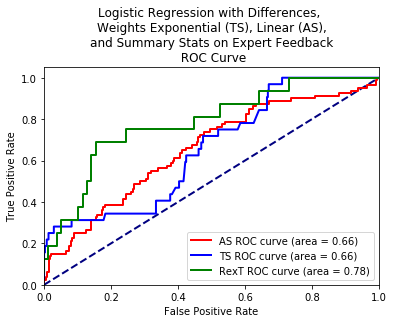

In [139]:
# ROC Curve
utils.model_roc_curves(roc_data_dict={'AS' : AS_logistic_reg_roc_curve_expert, 
                                'TS' : TS_logistic_reg_roc_curve_expert, 
                                'RexT' : RexT_logistic_reg_roc_curve_expert}, 
                 auc_dict={'AS' : AS_logistic_reg_roc_curve_AUC_expert, 
                           'TS' : TS_logistic_reg_roc_curve_AUC_expert, 
                           'RexT' : RexT_logistic_reg_roc_curve_AUC_expert}, 
                 method_name='Logistic Regression with Differences, \nWeights Exponential (TS), Linear (AS),\nand Summary Stats on Expert Feedback\n')

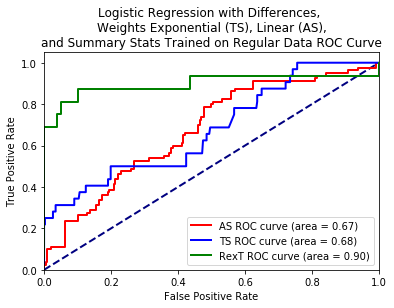

In [140]:
# ROC Curve
utils.model_roc_curves(roc_data_dict={'AS' : AS_logistic_reg_roc_curve_diff, 
                                'TS' : TS_logistic_reg_roc_curve_diff, 
                                'RexT' : RexT_logistic_reg_roc_curve_diff}, 
                 auc_dict={'AS' : AS_logistic_reg_roc_curve_AUC_diff, 
                           'TS' : TS_logistic_reg_roc_curve_AUC_diff, 
                           'RexT' : RexT_logistic_reg_roc_curve_AUC_diff}, 
                 method_name='Logistic Regression with Differences, \nWeights Exponential (TS), Linear (AS),\nand Summary Stats Trained on Regular Data')

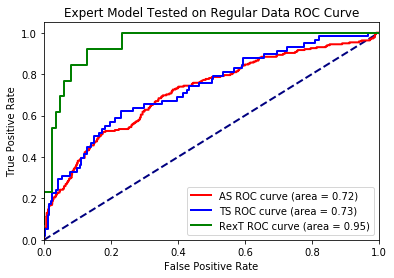

In [57]:
# ROC Curve
utils.model_roc_curves(roc_data_dict={'AS' : AS_logistic_reg_roc_curve_expert_diff, 
                                'TS' : TS_logistic_reg_roc_curve_expert_diff, 
                                'RexT' : RexT_logistic_reg_roc_curve_expert_diff}, 
                 auc_dict={'AS' : AS_logistic_reg_roc_curve_AUC_expert_diff, 
                           'TS' : TS_logistic_reg_roc_curve_AUC_expert_diff, 
                           'RexT' : RexT_logistic_reg_roc_curve_AUC_expert_diff}, 
                 method_name='Expert Model Tested on Regular Data')

##### Confusion Matrix for Expert Model

TP to FP ratio: 1.67


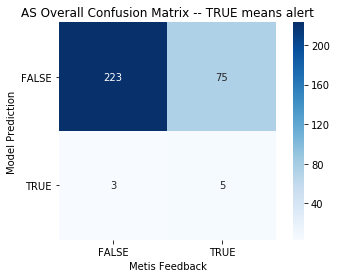

In [58]:
AS_threshold = 0.6
utils.confusion_matrix_visual(AS_y_test_expert, 
                        AS_logistic_regression_model_expert.predict_proba(AS_X_test_expert)[:,1] \
                        >= AS_threshold, 'AS Overall')

TP to FP ratio: inf


C:\Users\s.molin\scope_model_case_study\pymodelutils\utils.py:315: RuntimeWarning: divide by zero encountered in longlong_scalars
  print('TP to FP ratio: ' + str(round(mat[1,1] / mat[0,1], 2)))


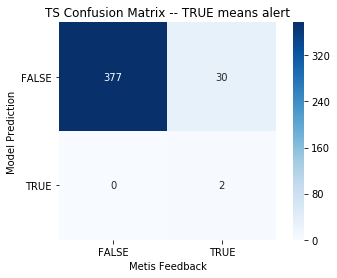

In [59]:
TS_threshold = 0.5
utils.confusion_matrix_visual(TS_y_test_expert, 
                        TS_logistic_regression_model_expert.predict_proba(TS_X_test_expert)[:,1] \
                        >= TS_threshold,
                        'TS')

TP to FP ratio: 0.83


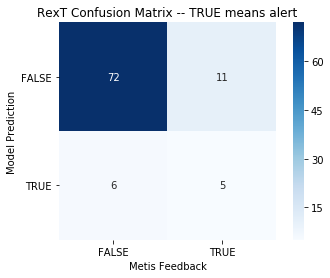

In [60]:
RexT_threshold = 0.7
utils.confusion_matrix_visual(RexT_y_test_expert, 
                        RexT_logistic_regression_model_expert.predict_proba(RexT_X_test_expert)[:,1] \
                        >= RexT_threshold,
                        'RexT')

#### Metrics for Expert Model

In [61]:
utils.classification_report_all(y_test_dict={'AS' : AS_y_test_expert, 
                                       'TS' : TS_y_test_expert, 
                                       'RexT' : RexT_y_test_expert},
                         y_pred_dict={'AS' : 
                                      AS_logistic_regression_model_expert.predict_proba(AS_X_test_expert)[:,1] >= \
                                      AS_threshold, 
                                      'TS' : 
                                      TS_logistic_regression_model_expert.predict_proba(TS_X_test_expert)[:,1] >= \
                                      TS_threshold, 
                                      'RexT' : 
                                      RexT_logistic_regression_model_expert.predict_proba(RexT_X_test_expert)[:,1] >= \
                                      RexT_threshold})

AS results
             precision    recall  f1-score   support

      False       0.75      0.99      0.85       226
       True       0.62      0.06      0.11        80

avg / total       0.72      0.75      0.66       306

Percent misclassified: 25.49%
Count misclassified: 78
------------------------------------------------------
TS results
             precision    recall  f1-score   support

      False       0.93      1.00      0.96       377
       True       1.00      0.06      0.12        32

avg / total       0.93      0.93      0.90       409

Percent misclassified: 7.33%
Count misclassified: 30
------------------------------------------------------
RexT results
             precision    recall  f1-score   support

      False       0.87      0.92      0.89        78
       True       0.45      0.31      0.37        16

avg / total       0.80      0.82      0.81        94

Percent misclassified: 18.09%
Count misclassified: 17


##### Confusion Matrix for Regular Model on Same Data

TP to FP ratio: 0.83


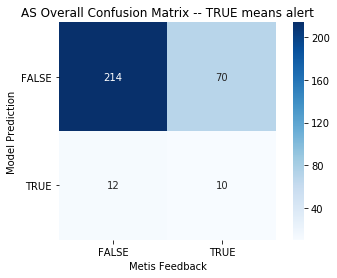

In [62]:
AS_threshold = 0.4
utils.confusion_matrix_visual(AS_y_test_expert, 
                        AS_logistic_regression_model_diff.predict_proba(AS_X_test_expert)[:,1] \
                        >= AS_threshold, 'AS Overall')

TP to FP ratio: 0.52


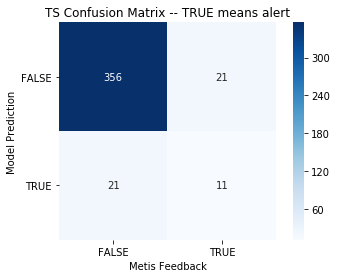

In [63]:
TS_threshold = 0.15
utils.confusion_matrix_visual(TS_y_test_expert, 
                        TS_logistic_regression_model_diff.predict_proba(TS_X_test_expert)[:,1] \
                        >= TS_threshold,
                        'TS')

TP to FP ratio: 11.0


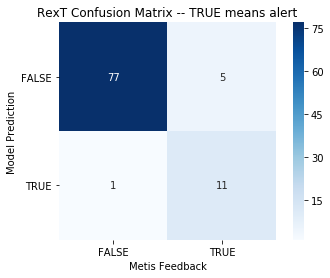

In [64]:
RexT_threshold = 0.17
utils.confusion_matrix_visual(RexT_y_test_expert, 
                        RexT_logistic_regression_model_diff.predict_proba(RexT_X_test_expert)[:,1] \
                        >= RexT_threshold,
                        'RexT')

#### Metrics for Regular Model on Same Data

In [65]:
utils.classification_report_all(y_test_dict={'AS' : AS_y_test_diff, 
                                       'TS' : TS_y_test_diff, 
                                       'RexT' : RexT_y_test_diff},
                         y_pred_dict={'AS' : 
                                      AS_logistic_regression_model_diff.predict_proba(AS_X_test_diff)[:,1] >= \
                                      AS_threshold, 
                                      'TS' : 
                                      TS_logistic_regression_model_diff.predict_proba(TS_X_test_diff)[:,1] >= \
                                      TS_threshold, 
                                      'RexT' : 
                                      RexT_logistic_regression_model_diff.predict_proba(RexT_X_test_diff)[:,1] >= \
                                      RexT_threshold})

AS results
             precision    recall  f1-score   support

      False       0.81      0.97      0.88       775
       True       0.64      0.20      0.30       215

avg / total       0.78      0.80      0.76       990

Percent misclassified: 19.8%
Count misclassified: 196
------------------------------------------------------
TS results
             precision    recall  f1-score   support

      False       0.94      0.96      0.95       638
       True       0.40      0.31      0.35        58

avg / total       0.89      0.90      0.90       696

Percent misclassified: 9.63%
Count misclassified: 67
------------------------------------------------------
RexT results
             precision    recall  f1-score   support

      False       0.97      0.99      0.98        86
       True       0.91      0.77      0.83        13

avg / total       0.96      0.96      0.96        99

Percent misclassified: 4.04%
Count misclassified: 4


### Logistic Regression with Differences using Extra Alerts

In [66]:
%%capture 
# ^ don't print errors about precision, recall, F1-score being 0

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, fbeta_score, zero_one_loss

logistic_regression = LogisticRegression(penalty='l2', tol=0.0001, C=1.0, 
                                         fit_intercept=True, random_state=42, 
                                         max_iter=100, verbose=0, n_jobs=-1)
parameters = {'penalty' : ('l2', 'l1'),
              'C':[i/10 for i in range(11) if i > 0],
#              'fit_intercept' : [True, False],
             'class_weight' : ['balanced', None],
             'intercept_scaling' : [0.5, 1, 1.5, 2, 2.5, 3]}

scoring = {'auc': 'roc_auc',
           # only reports on alerts flagged
           'precision_binary' : make_scorer(precision_score, average='binary'), 
           # global count of everything like confusion matrix
           'precision_micro' : make_scorer(precision_score, average='micro'), 
           # metrics calculated for each label and averaged evenly (regardless of class size)
#            'precision_macro' : make_scorer(precision_score, average='macro'), 
           # same as macro but with a weighted average to account for imbalance of the classes
           'precision_weighted' : make_scorer(precision_score, average='weighted'),
          'recall_weighted' : make_scorer(recall_score, average='weighted'),
          'recall_binary' : make_scorer(recall_score, average='binary'),
          'recall_micro' : make_scorer(recall_score, average='micro'),
#           'recall_macro' : make_scorer(recall_score, average='macro'),
          'f1_score_weighted' : make_scorer(f1_score, average='weighted'),
          'f1_score_binary' : make_scorer(f1_score, average='binary'),
          'f1_score_micro' : make_scorer(f1_score, average='micro'),
#           'f1_score_macro' : make_scorer(f1_score, average='macro'),
           # emphasize recall more
          'f2_score_weighted' : make_scorer(fbeta_score, beta=2, average='weighted'), 
          'f2_score_binary' : make_scorer(fbeta_score, beta=2, average='binary'),
          'f2_score_micro' : make_scorer(fbeta_score, beta=2, average='micro'),
#           'f2_score_macro' : make_scorer(fbeta_score, beta=2, average='macro'),
           # emphasize precision more
          'f0.5_score_weighted' : make_scorer(fbeta_score, beta=0.5, average='weighted'), 
          'f0.5_score_binary' : make_scorer(fbeta_score, beta=0.5, average='binary'),
          'f0.5_score_micro' : make_scorer(fbeta_score, beta=0.5, average='micro'),
#           'f0.5_score_macro' : make_scorer(fbeta_score, beta=0.5, average='macro'),
           # percent of misclassifications
          'zero_one_loss_normalized' : make_scorer(zero_one_loss, greater_is_better=False), 
           # number of misclassifications
          'zero_one_loss_count' : make_scorer(zero_one_loss, greater_is_better=False, 
                                              normalize=False), 
          'accuracy' : 'accuracy'}

# pick '_weighted' if you want to be right on each class proportionally 
# ('macro' isn't really appropriate due to the class imbalance)
# pick '_binary' if you want to perform best on the alert class
# pick '_micro' to count globally all TP, FP, TN, FN (like confusion matrix)
# so for our purposes 'f1_score' with one of the above is likely to be the best
refit_AS = 'precision_weighted'
refit_TS = 'precision_micro'
refit_RexT = 'auc'

AS_logistic_grid = GridSearchCV(estimator=logistic_regression, param_grid=parameters, 
                                scoring=scoring, refit=refit_AS, return_train_score=True)
TS_logistic_grid = GridSearchCV(estimator=logistic_regression, param_grid=parameters, 
                                scoring=scoring, refit=refit_TS, return_train_score=True)
RexT_logistic_grid = GridSearchCV(estimator=logistic_regression, param_grid=parameters, 
                                  scoring=scoring, refit=refit_RexT, return_train_score=True)

# fit the models to find the best version
AS_logistic_regression_model_diff = AS_logistic_grid.fit(AS_X_train_oversampled, AS_y_train_oversampled)
TS_logistic_regression_model_diff = TS_logistic_grid.fit(TS_X_train_oversampled, TS_y_train_oversampled)
RexT_logistic_regression_model_diff = RexT_logistic_grid.fit(RexT_X_train_oversampled, RexT_y_train_oversampled)

#### Best Logistic Regression Models
##### AS
The model seems to pick up that the most important features are whether or not it is a campaign, the 5 most recent dates (time_delta's 1-5). TAC, margin, and RexT euro have very negative coefficients most likely because we don't see many alerts there so the log odds are small and the exponential of those values is near 0. Clicks, displays, and spend are more likely.

In [67]:
print(AS_logistic_regression_model_diff.best_estimator_)
print(refit_AS + ' (Mean cross-validated score of the best_estimator): ' + \
      str(AS_logistic_regression_model_diff.best_score_))
for col, coef in zip(AS_X_train_diff.columns, AS_logistic_regression_model_diff.best_estimator_.coef_[0]):
    print(col + '\t' + str(round(coef, 2)))

LogisticRegression(C=0.3, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1.5, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
precision_weighted (Mean cross-validated score of the best_estimator): 0.6759768188728427
is_campaign	0.38
time_delta_01	0.3
time_delta_02	0.2
time_delta_03	0.04
time_delta_04	0.02
time_delta_05	0.0
time_delta_06	0.09
time_delta_07	0.01
time_delta_08	-0.07
time_delta_09	0.0
time_delta_10	0.0
time_delta_11	0.03
time_delta_12	0.63
time_delta_13	0.0
time_delta_14	0.0
time_delta_15	0.0
time_delta_16	-0.06
time_delta_17	0.0
time_delta_18	0.0
time_delta_19	0.0
time_delta_20	0.0
time_delta_21	0.0
time_delta_22	0.0
time_delta_23	0.0
time_delta_24	0.0
time_delta_25	0.0
kpi_clicks	0.23
kpi_client_rext	0.0
kpi_conversions	0.0
kpi_cos	0.25
kpi_cr	0.22
kpi_ctr	0.28
kpi_displays	-0.1
kpi_margin	-1.38
kpi_order_value	-0.2
kpi_rext_eu

##### TS

In [68]:
print(TS_logistic_regression_model_diff.best_estimator_)
print(refit_TS + ' (Mean cross-validated score of the best_estimator): ' + \
      str(TS_logistic_regression_model_diff.best_score_))
for col, coef in zip(TS_X_train_diff.columns, TS_logistic_regression_model_diff.best_estimator_.coef_[0]):
    print(col + '\t' + str(round(coef, 2)))

LogisticRegression(C=0.2, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1.5, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
precision_micro (Mean cross-validated score of the best_estimator): 0.6408091123330715
time_delta_01	2.42
time_delta_02	0.01
time_delta_03	-0.0
time_delta_04	-0.0
time_delta_05	0.0
time_delta_06	0.0
time_delta_07	-0.0
time_delta_08	-0.0
time_delta_09	-0.0
time_delta_10	-0.0
time_delta_11	-0.0
time_delta_12	0.0
time_delta_13	0.0
time_delta_14	-0.0
time_delta_15	-0.0
time_delta_16	-0.0
time_delta_17	-0.0
time_delta_18	0.0
time_delta_19	0.0
time_delta_20	0.0
time_delta_21	-0.0
time_delta_22	-0.0
time_delta_23	0.0
time_delta_24	0.0
time_delta_25	0.0
site_type_SITE LEVEL	-0.13
site_type_aa	0.2
site_type_aios	-0.6
site_type_d	-0.52
site_type_m	0.39
site_type_t	-0.06
event_name_basket	-0.37
event_name_homepage	-0.16
event_nam

##### RexT

In [69]:
print(RexT_logistic_regression_model_diff.best_estimator_)
print(refit_RexT + ' (Mean cross-validated score of the best_estimator): ' + \
      str(RexT_logistic_regression_model_diff.best_score_))
for col, coef in zip(RexT_X_train_diff.columns, RexT_logistic_regression_model_diff.best_estimator_.coef_[0]):
    print(col + '\t' + str(round(coef, 2)))

LogisticRegression(C=0.2, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=2, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
auc (Mean cross-validated score of the best_estimator): 0.9996296296296296
time_delta_01	1.36
time_delta_02	0.0
time_delta_03	0.0
time_delta_04	0.0
time_delta_05	0.0
time_delta_06	0.0
time_delta_07	0.0
time_delta_08	0.0
time_delta_09	0.0
time_delta_10	-0.37
time_delta_11	0.0
time_delta_12	0.0
time_delta_13	0.0
time_delta_14	0.0
time_delta_15	0.0
time_delta_16	0.0
time_delta_17	0.0
time_delta_18	0.0
time_delta_19	0.0
time_delta_20	0.0
time_delta_21	0.0
time_delta_22	0.0
time_delta_23	0.0
time_delta_24	-0.21
time_delta_25	0.0
time_delta_26	0.0
time_delta_27	-0.27
time_delta_28	0.0
time_delta_29	0.0
time_delta_30	0.0
time_delta_diff_29	-0.1
time_delta_diff_28	0.0
time_delta_diff_27	0.0
time_delta_diff_26	0.0
time_delta_diff

#### Model Evaluation
##### ROC Curve

In [70]:
from sklearn.metrics import roc_curve, auc

AS_y_prob_fit_diff = AS_logistic_regression_model_diff.predict_proba(AS_X_test_diff)
TS_y_prob_fit_diff = TS_logistic_regression_model_diff.predict_proba(TS_X_test_diff)
RexT_y_prob_fit_diff = RexT_logistic_regression_model_diff.predict_proba(RexT_X_test_diff)

AS_logistic_reg_roc_curve_diff = roc_curve(AS_y_test_diff, AS_y_prob_fit_diff[:,1], 
                                           pos_label=1) # returns tuple: fpr, tpr, thresholds
AS_logistic_reg_roc_curve_AUC_diff = auc(AS_logistic_reg_roc_curve_diff[0], 
                                        AS_logistic_reg_roc_curve_diff[1]) # needs fpr, tpr
TS_logistic_reg_roc_curve_diff = roc_curve(TS_y_test_diff, TS_y_prob_fit_diff[:,1], pos_label=1)
TS_logistic_reg_roc_curve_AUC_diff = auc(TS_logistic_reg_roc_curve_diff[0], 
                                        TS_logistic_reg_roc_curve_diff[1])
RexT_logistic_reg_roc_curve_diff = roc_curve(RexT_y_test_diff, RexT_y_prob_fit_diff[:,1], pos_label=1)
RexT_logistic_reg_roc_curve_AUC_diff = auc(RexT_logistic_reg_roc_curve_diff[0], 
                                          RexT_logistic_reg_roc_curve_diff[1])

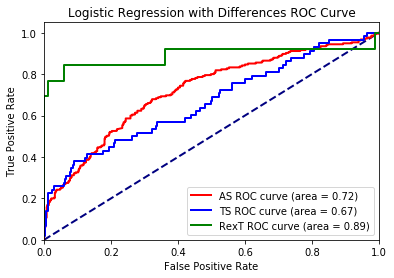

In [47]:
# ROC Curve
utils.model_roc_curves(roc_data_dict={'AS' : AS_logistic_reg_roc_curve_diff, 
                                'TS' : TS_logistic_reg_roc_curve_diff, 
                                'RexT' : RexT_logistic_reg_roc_curve_diff}, 
                 auc_dict={'AS' : AS_logistic_reg_roc_curve_AUC_diff, 
                           'TS' : TS_logistic_reg_roc_curve_AUC_diff, 
                           'RexT' : RexT_logistic_reg_roc_curve_AUC_diff}, 
                 method_name='Logistic Regression with Differences')

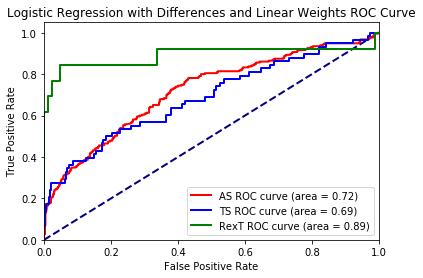

In [54]:
# ROC Curve
utils.model_roc_curves(roc_data_dict={'AS' : AS_logistic_reg_roc_curve_diff, 
                                'TS' : TS_logistic_reg_roc_curve_diff, 
                                'RexT' : RexT_logistic_reg_roc_curve_diff}, 
                 auc_dict={'AS' : AS_logistic_reg_roc_curve_AUC_diff, 
                           'TS' : TS_logistic_reg_roc_curve_AUC_diff, 
                           'RexT' : RexT_logistic_reg_roc_curve_AUC_diff}, 
                 method_name='Logistic Regression with Differences and Linear Weights')

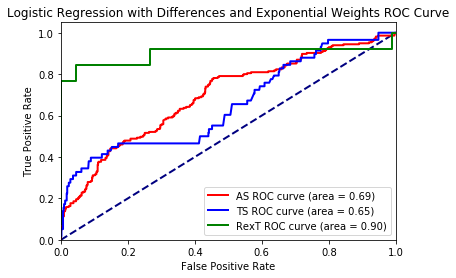

In [46]:
# ROC Curve
utils.model_roc_curves(roc_data_dict={'AS' : AS_logistic_reg_roc_curve_diff, 
                                'TS' : TS_logistic_reg_roc_curve_diff, 
                                'RexT' : RexT_logistic_reg_roc_curve_diff}, 
                 auc_dict={'AS' : AS_logistic_reg_roc_curve_AUC_diff, 
                           'TS' : TS_logistic_reg_roc_curve_AUC_diff, 
                           'RexT' : RexT_logistic_reg_roc_curve_AUC_diff}, 
                 method_name='Logistic Regression with Differences and Exponential Weights')

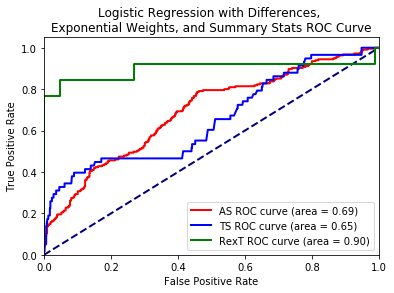

In [35]:
# ROC Curve
utils.model_roc_curves(roc_data_dict={'AS' : AS_logistic_reg_roc_curve_diff, 
                                'TS' : TS_logistic_reg_roc_curve_diff, 
                                'RexT' : RexT_logistic_reg_roc_curve_diff}, 
                 auc_dict={'AS' : AS_logistic_reg_roc_curve_AUC_diff, 
                           'TS' : TS_logistic_reg_roc_curve_AUC_diff, 
                           'RexT' : RexT_logistic_reg_roc_curve_AUC_diff}, 
                 method_name='Logistic Regression with Differences, \nExponential Weights, and Summary Stats')

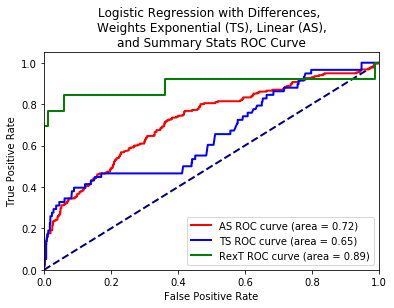

In [86]:
# ROC Curve
utils.model_roc_curves(roc_data_dict={'AS' : AS_logistic_reg_roc_curve_diff, 
                                'TS' : TS_logistic_reg_roc_curve_diff, 
                                'RexT' : RexT_logistic_reg_roc_curve_diff}, 
                 auc_dict={'AS' : AS_logistic_reg_roc_curve_AUC_diff, 
                           'TS' : TS_logistic_reg_roc_curve_AUC_diff, 
                           'RexT' : RexT_logistic_reg_roc_curve_AUC_diff}, 
                 method_name='Logistic Regression with Differences, \nWeights Exponential (TS), Linear (AS),\nand Summary Stats')

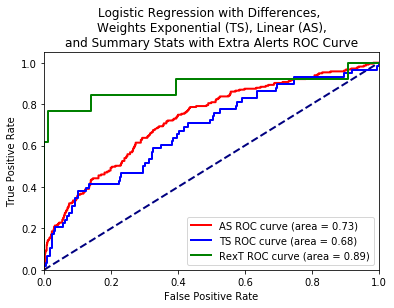

In [71]:
# ROC Curve
utils.model_roc_curves(roc_data_dict={'AS' : AS_logistic_reg_roc_curve_diff, 
                                'TS' : TS_logistic_reg_roc_curve_diff, 
                                'RexT' : RexT_logistic_reg_roc_curve_diff}, 
                 auc_dict={'AS' : AS_logistic_reg_roc_curve_AUC_diff, 
                           'TS' : TS_logistic_reg_roc_curve_AUC_diff, 
                           'RexT' : RexT_logistic_reg_roc_curve_AUC_diff}, 
                 method_name='Logistic Regression with Differences, \nWeights Exponential (TS), Linear (AS),\nand Summary Stats with Extra Alerts')

##### Check Alert Counts at Certain Threshold

In [71]:
utils.threshold_results(AS_logistic_regression_model_diff.predict_proba(AS_X_test_diff),
                  TS_logistic_regression_model_diff.predict_proba(TS_X_test_diff),
                  RexT_logistic_regression_model_diff.predict_proba(RexT_X_test_diff))

0% threshold
AS alert count: 990
TS alert count: 696
RexT alert count: 99
---------------------------------------------------------
10% threshold
AS alert count: 983
TS alert count: 696
RexT alert count: 41
---------------------------------------------------------
20% threshold
AS alert count: 876
TS alert count: 696
RexT alert count: 26
---------------------------------------------------------
30% threshold
AS alert count: 717
TS alert count: 693
RexT alert count: 21
---------------------------------------------------------
40% threshold
AS alert count: 565
TS alert count: 468
RexT alert count: 15
---------------------------------------------------------
50% threshold
AS alert count: 423
TS alert count: 310
RexT alert count: 11
---------------------------------------------------------
60% threshold
AS alert count: 268
TS alert count: 63
RexT alert count: 9
---------------------------------------------------------
70% threshold
AS alert count: 115
TS alert count: 9
RexT alert count: 6


##### Confusion Matrix

TP to FP ratio: 2.25


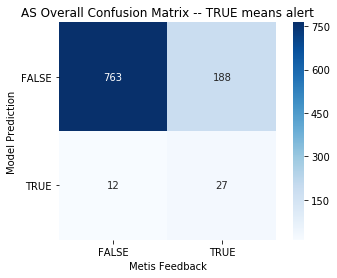

In [72]:
AS_threshold = 0.8
utils.confusion_matrix_visual(AS_y_test_diff, 
                        AS_logistic_regression_model_diff.predict_proba(AS_X_test_diff)[:,1] \
                        >= AS_threshold, 'AS Overall')

TP to FP ratio: 2.0


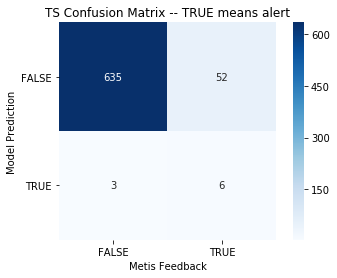

In [77]:
TS_threshold = 0.7
utils.confusion_matrix_visual(TS_y_test_diff, 
                        TS_logistic_regression_model_diff.predict_proba(TS_X_test_diff)[:,1] \
                        >= TS_threshold,
                        'TS')

TP to FP ratio: 10.0


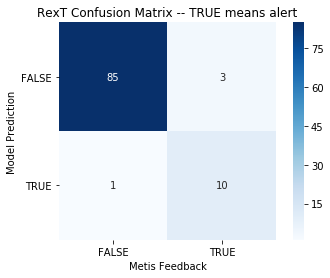

In [79]:
RexT_threshold = 0.5
utils.confusion_matrix_visual(RexT_y_test_diff, 
                        RexT_logistic_regression_model_diff.predict_proba(RexT_X_test_diff)[:,1] \
                        >= RexT_threshold,
                        'RexT')

On disqualified data.

TP to FP ratio: 1.02


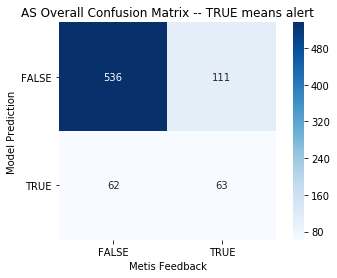

In [80]:
utils.confusion_matrix_visual(disqualified_AS['min_max']['is_alert'], 
                        AS_logistic_regression_model_diff.predict_proba(disqualified_AS['min_max'].\
                                                                   drop([col for col in disqualified_AS['min_max'].columns
                                                                        if col in ['run_date', 'series', 'is_alert']], axis=1))[:,1] \
                        >= AS_threshold, 'AS Overall')

TP to FP ratio: 1.0


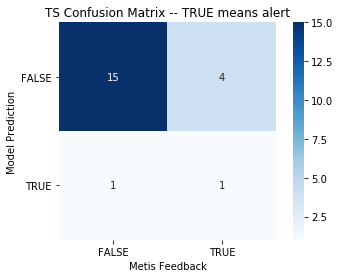

In [81]:
utils.confusion_matrix_visual(disqualified_TS['min_max']['is_alert'], 
                        TS_logistic_regression_model_diff.predict_proba(disqualified_TS['min_max'].\
                                                                   drop([col for col in disqualified_TS['min_max'].columns
                                                                        if col in ['run_date', 'series', 'is_alert']], axis=1))[:,1] \
                        >= TS_threshold,
                        'TS')

#### Metrics

In [82]:
utils.classification_report_all(y_test_dict={'AS' : AS_y_test_diff, 
                                       'TS' : TS_y_test_diff, 
                                       'RexT' : RexT_y_test_diff},
                         y_pred_dict={'AS' : 
                                      AS_logistic_regression_model_diff.predict_proba(AS_X_test_diff)[:,1] >= \
                                      AS_threshold, 
                                      'TS' : 
                                      TS_logistic_regression_model_diff.predict_proba(TS_X_test_diff)[:,1] >= \
                                      TS_threshold, 
                                      'RexT' : 
                                      RexT_logistic_regression_model_diff.predict_proba(RexT_X_test_diff)[:,1] >= \
                                      RexT_threshold})

AS results
             precision    recall  f1-score   support

      False       0.80      0.98      0.88       775
       True       0.69      0.13      0.21       215

avg / total       0.78      0.80      0.74       990

Percent misclassified: 20.2%
Count misclassified: 200
------------------------------------------------------
TS results
             precision    recall  f1-score   support

      False       0.92      1.00      0.96       638
       True       0.67      0.10      0.18        58

avg / total       0.90      0.92      0.89       696

Percent misclassified: 7.9%
Count misclassified: 55
------------------------------------------------------
RexT results
             precision    recall  f1-score   support

      False       0.97      0.99      0.98        86
       True       0.91      0.77      0.83        13

avg / total       0.96      0.96      0.96        99

Percent misclassified: 4.04%
Count misclassified: 4
